In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline


%load_ext autoreload
%autoreload 2

# import gzip
# from cyvcf2 import VCF

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()


In [2]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)


In [3]:
### Draw the old pareto front line from Li et al 2019
old_muts = merged_fitness[merged_fitness['source_publication'].isin(['Venkataram2015','Li2019'])]

points = old_muts[['FerPerHour_Li2019','ResPerHour_Li2019']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

pareto_line = (list(points[hull.vertices,0][5:-1])+[0],list(points[hull.vertices,1][5:-1])+[np.nanmax(old_muts['ResPerHour_Li2019'].values)])

# plt.plot(pareto_line[0],pareto_line[1], 'r--', lw=2)
# plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

In [4]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

In [5]:
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

for anc in anc_list:
    for evo_cond in evo_cond_list:
        this_pairing = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition']==evo_cond)]
        pure_diploids = this_pairing[this_pairing['class_new']=='pure_diploids']
        adaptive_nondiploids = this_pairing[~this_pairing['class_new'].isin(['pure_diploids','neutral_haploids'])]
        print(anc,evo_cond,len(this_pairing),len(pure_diploids),len(adaptive_nondiploids))

WT Evo1D 0 0 0
WT Evo2D 484 236 121
WT Evo3D 0 0 0
CYR1 Evo1D 211 101 6
CYR1 Evo2D 535 224 68
CYR1 Evo3D 35 7 22
GPB2 Evo1D 168 84 11
GPB2 Evo2D 1219 229 17
GPB2 Evo3D 34 19 14
TOR1 Evo1D 201 163 12
TOR1 Evo2D 726 317 57
TOR1 Evo3D 2 0 2
IRA1_MIS Evo1D 191 83 20
IRA1_MIS Evo2D 142 16 90
IRA1_MIS Evo3D 32 2 30
IRA1_NON Evo1D 12 0 12
IRA1_NON Evo2D 95 0 95
IRA1_NON Evo3D 134 0 134


In [6]:
def count_tradeoffs(data_x,data_y,
#                     error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=1.96,use_both_errors=False):
    
    if not use_both_errors:
    
        x_improved = (data_x>(background_data_x+multiplier*background_error_x))
        y_improved = (data_y>(background_data_y+multiplier*background_error_y))

        x_reduced = (data_x<(background_data_x-multiplier*background_error_x))
        y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
        
    else:
        scipy.stats.ttest_ind_from_stats(data_x,error_x)
    
    
    return improvement_matrix,len(data_x),both_indices

/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

FerPerHour ResPerHour
CYR1 ([[0, 0, 37], [0, 2, 17], [1, 6, 33]], 96)
CYR1 ['Evo1D'] ([[0, 0, 0], [0, 0, 1], [0, 2, 3]], 6, array([1, 2, 4])) [[0 0 0]
 [0 0 1]
 [0 2 3]]
CYR1 ['Evo1D'] ([[0, 0, 0], [0, 0, 1], [0, 2, 3]], 6)
CYR1 ['Evo2D'] ([[0, 0, 20], [0, 2, 14], [1, 4, 27]], 68, array([ 0,  2,  4,  5,  7,  9, 12, 14, 16, 18, 20, 24, 25, 36, 37, 39, 41,
       44, 46, 48, 49, 50, 56, 58, 59, 64, 67])) [[ 0  0 20]
 [ 0  2 14]
 [ 1  4 27]]
CYR1 ['Evo2D'] ([[0, 0, 20], [0, 2, 14], [1, 4, 27]], 68)
CYR1 ['Evo3D'] ([[0, 0, 17], [0, 0, 2], [0, 0, 3]], 22, array([11, 12, 20])) [[ 0  0 17]
 [ 0  0  2]
 [ 0  0  3]]
CYR1 ['Evo3D'] ([[0, 0, 17], [0, 0, 2], [0, 0, 3]], 22)
GPB2 ([[0, 1, 18], [0, 1, 11], [0, 2, 9]], 42)
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 4], [0, 2, 3]], 11, array([0, 5, 8])) [[0 0 2]
 [0 0 5]
 [0 4 6]]
GPB2 ['Evo1D'] ([[0, 0, 2], [0, 0, 4], [0, 2, 3]], 11)
GPB2 ['Evo2D'] ([[0, 1, 5], [0, 1, 5], [0, 0, 5]], 17, array([1, 2, 5, 8, 9])) [[ 0  1 25]
 [ 0  3 19]
 [ 1  4 32]]
GPB2 ['Evo

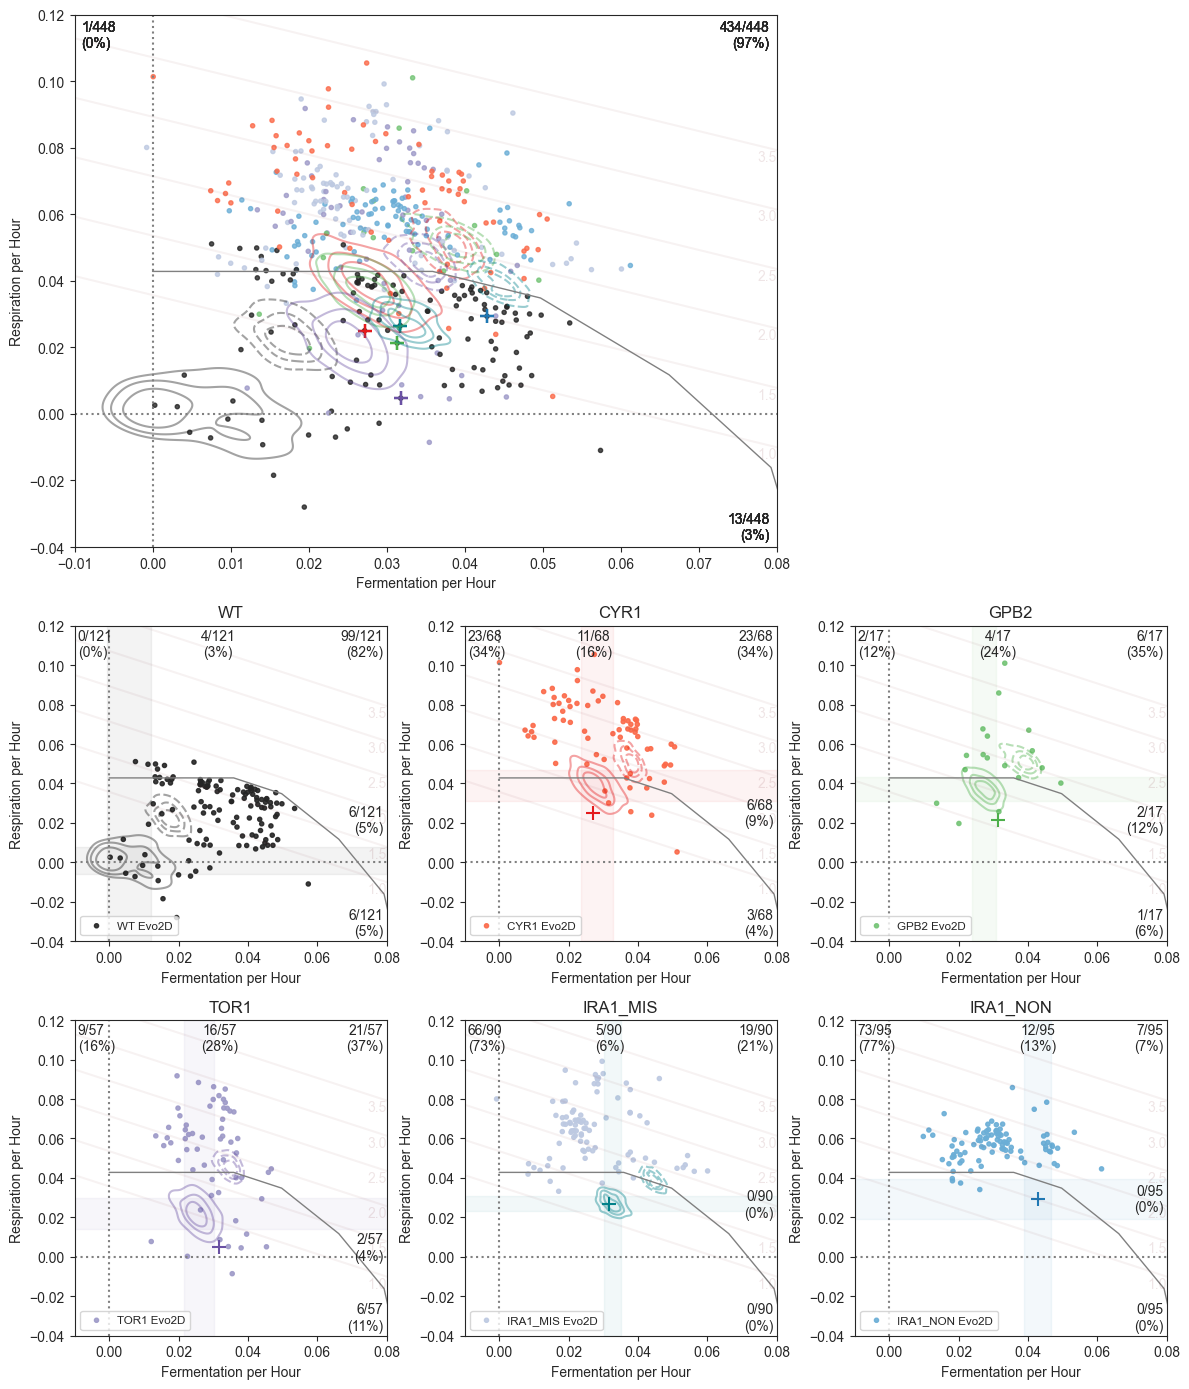

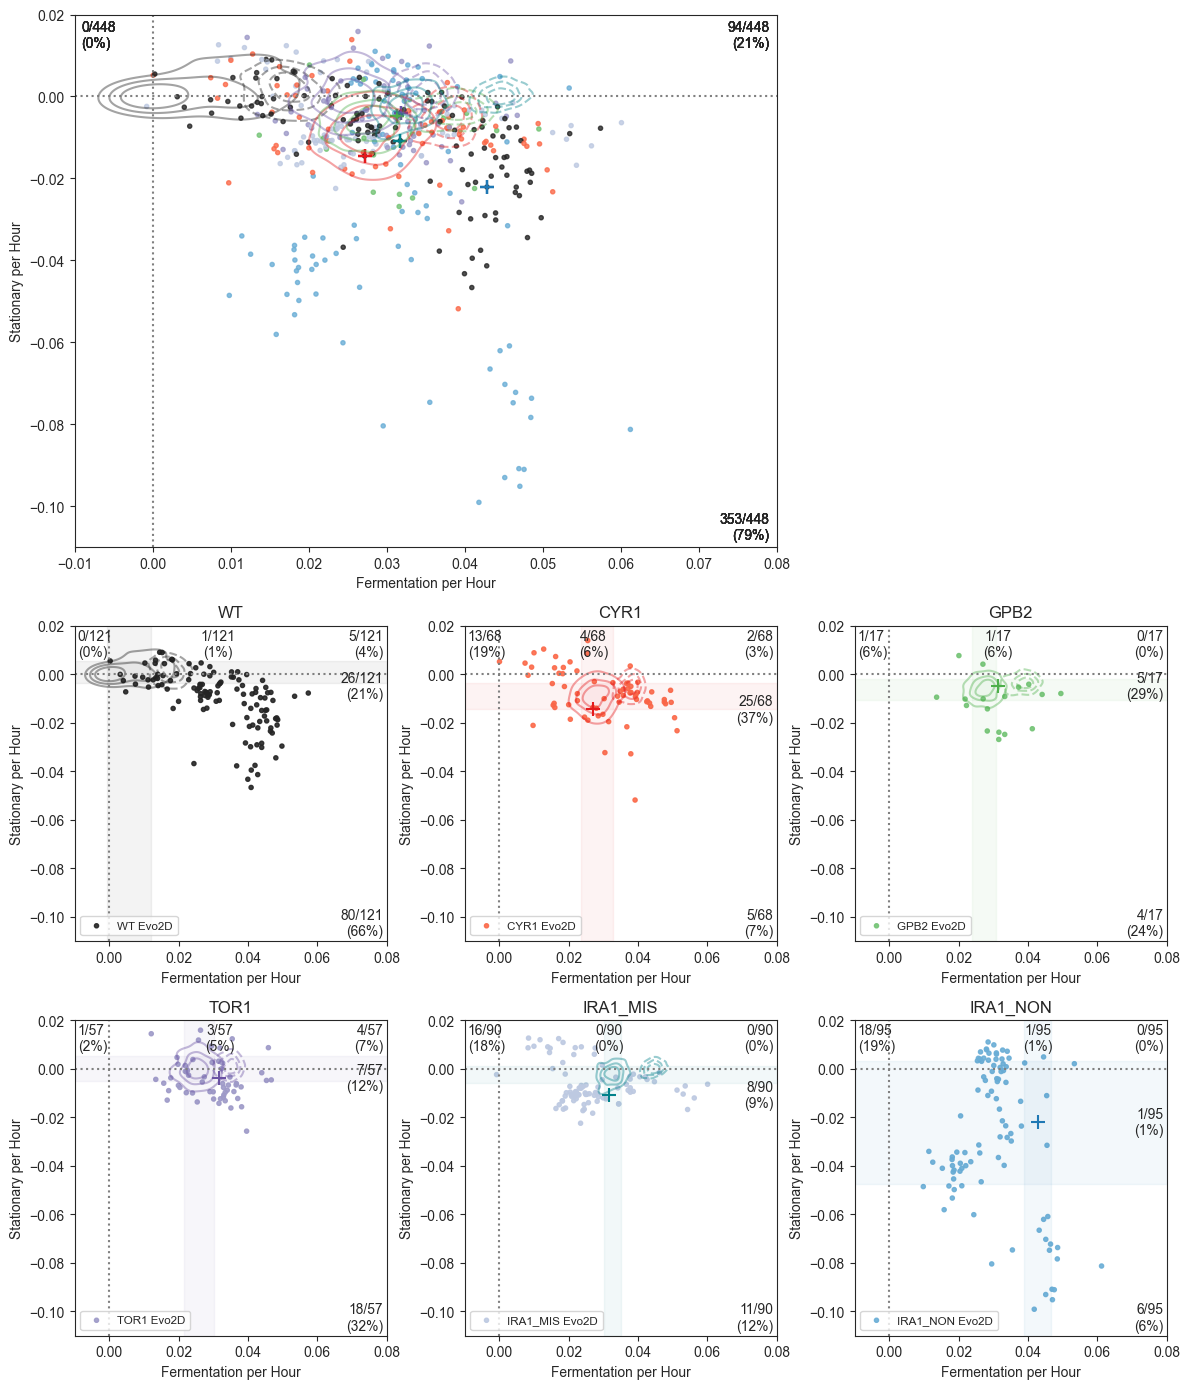

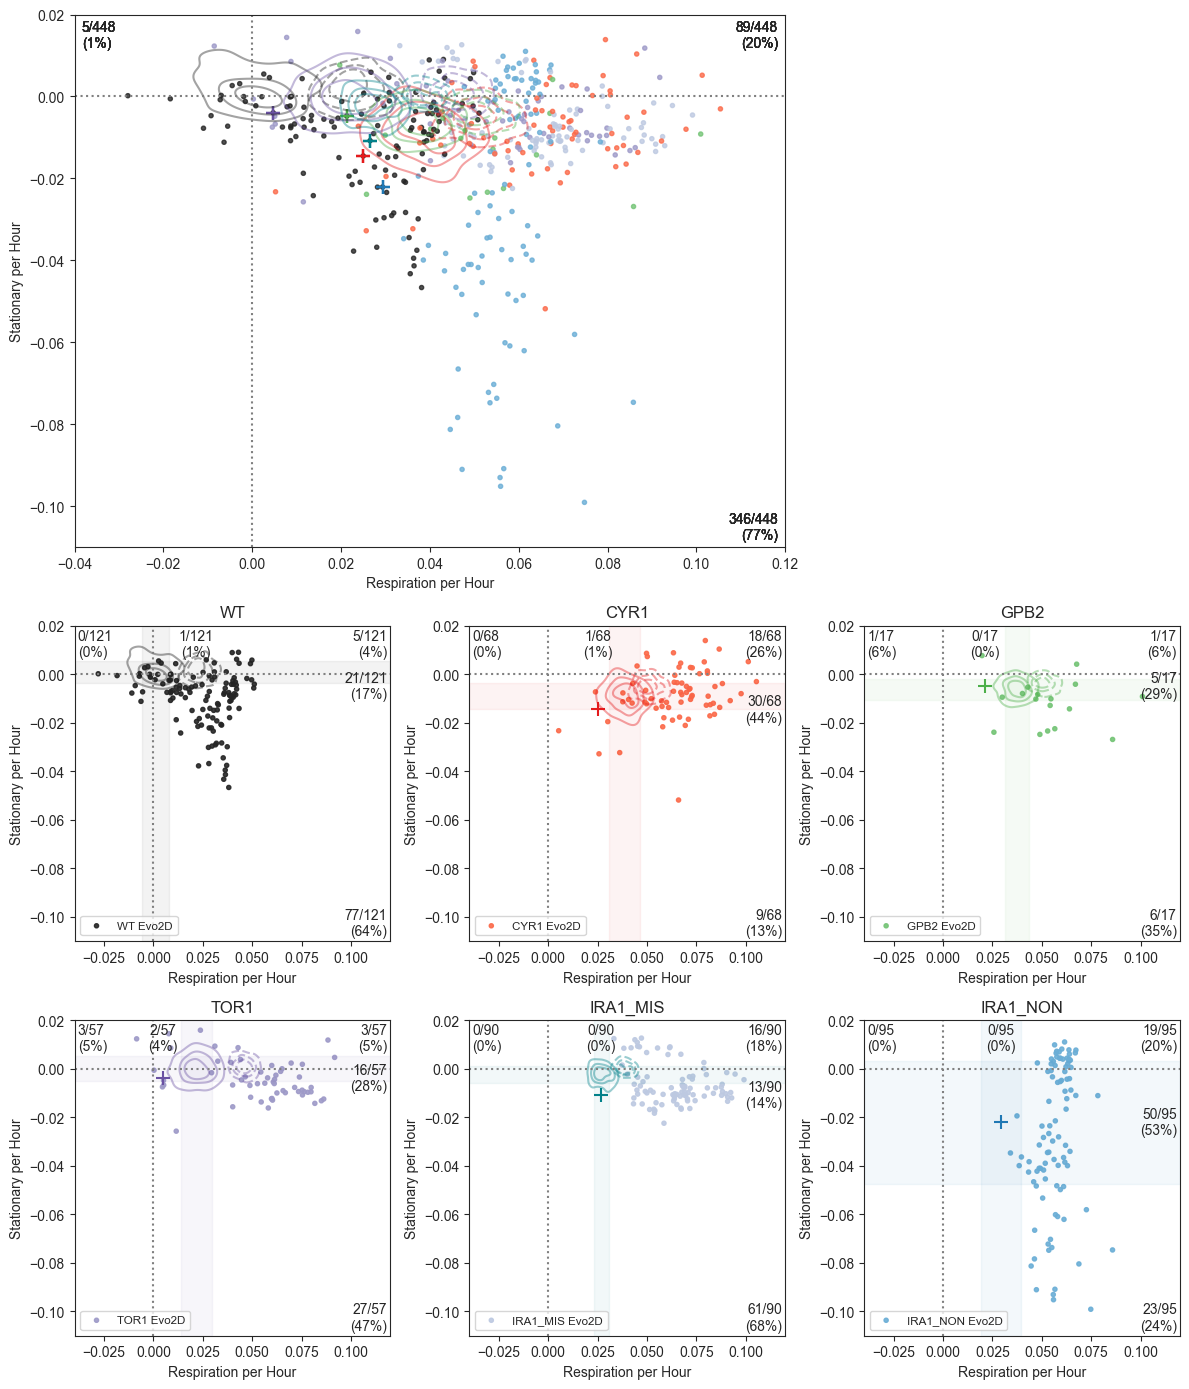

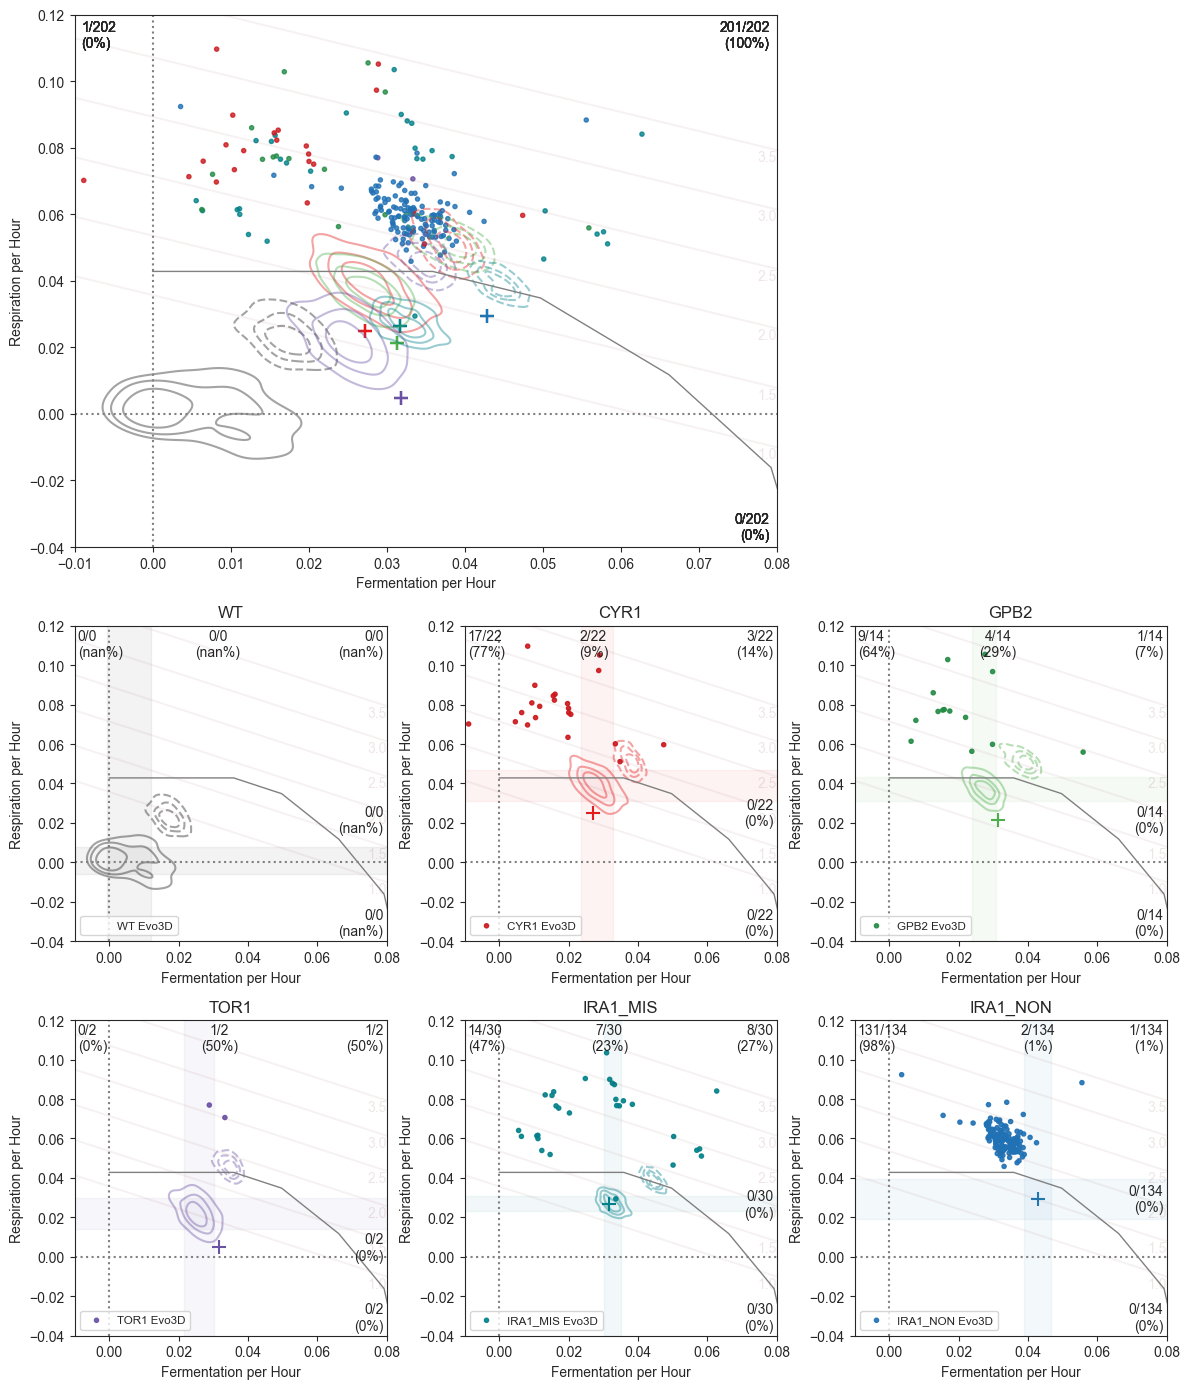

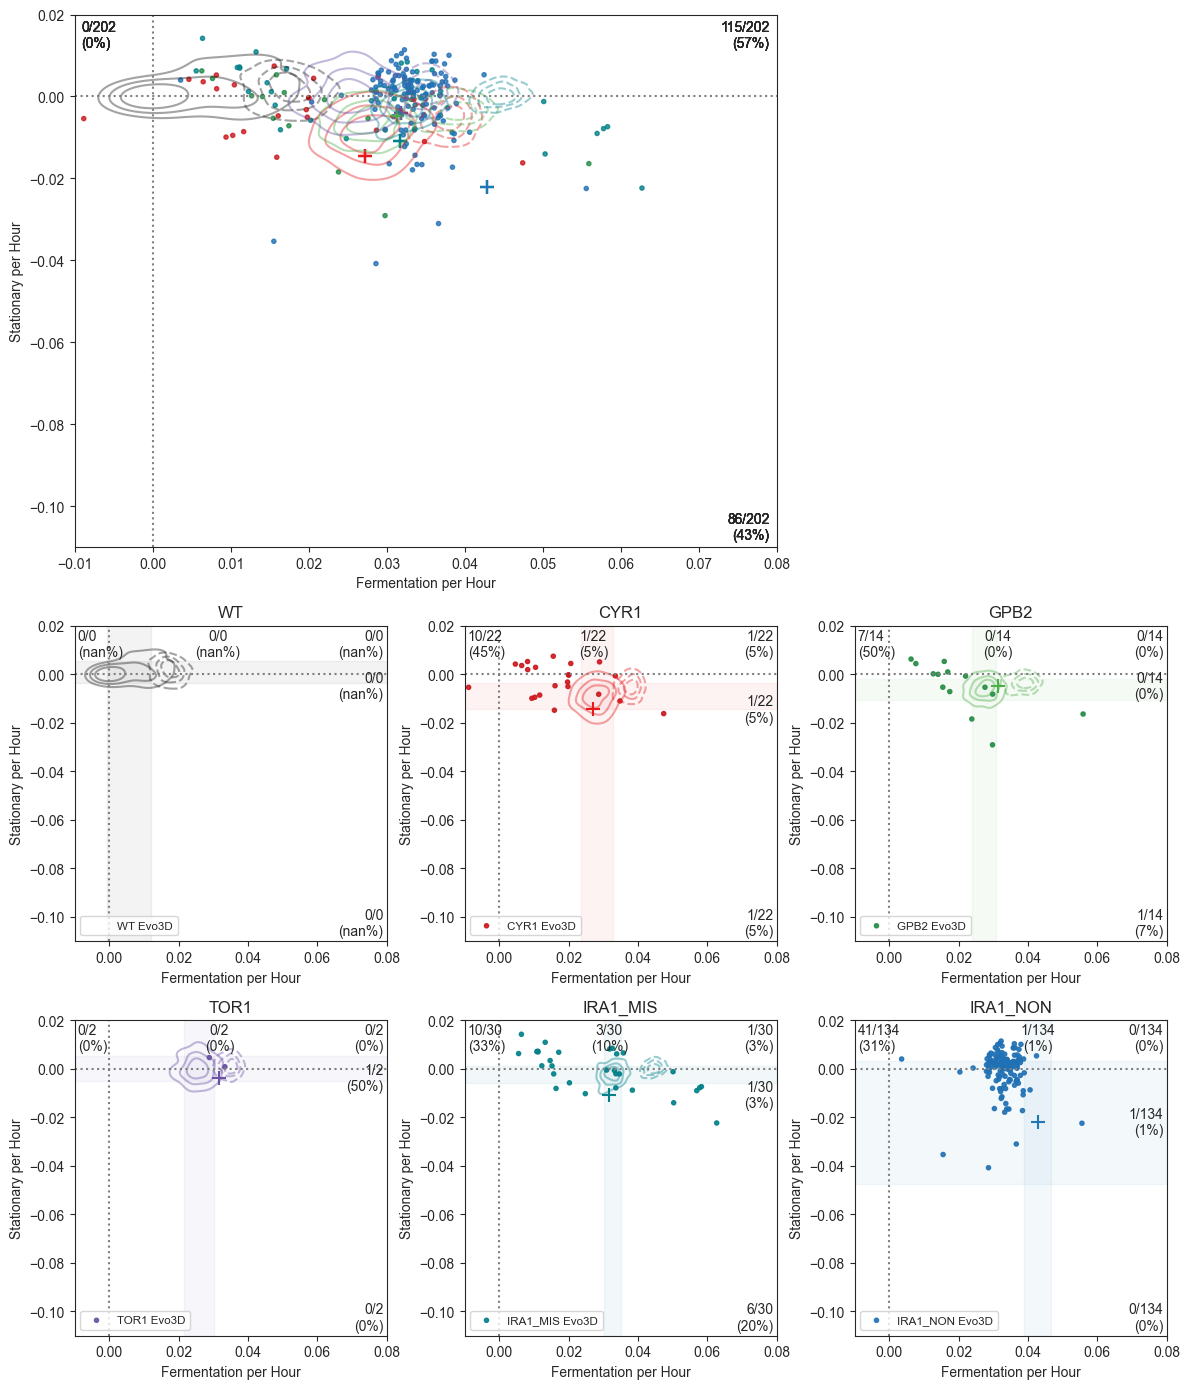

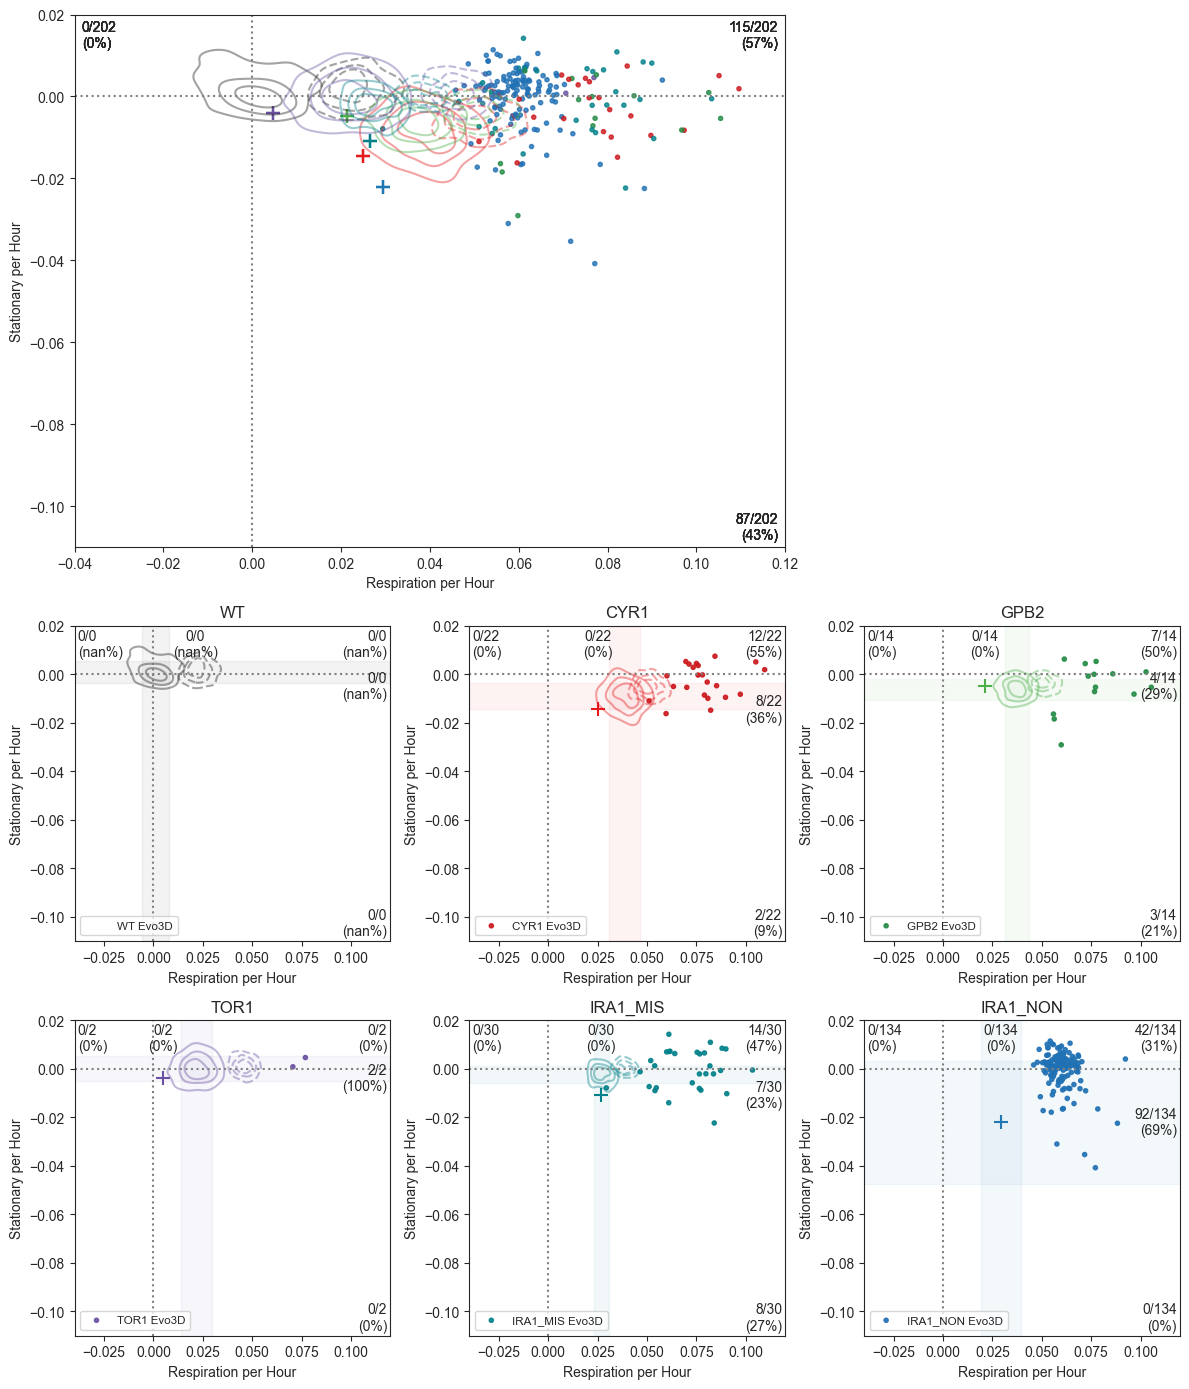

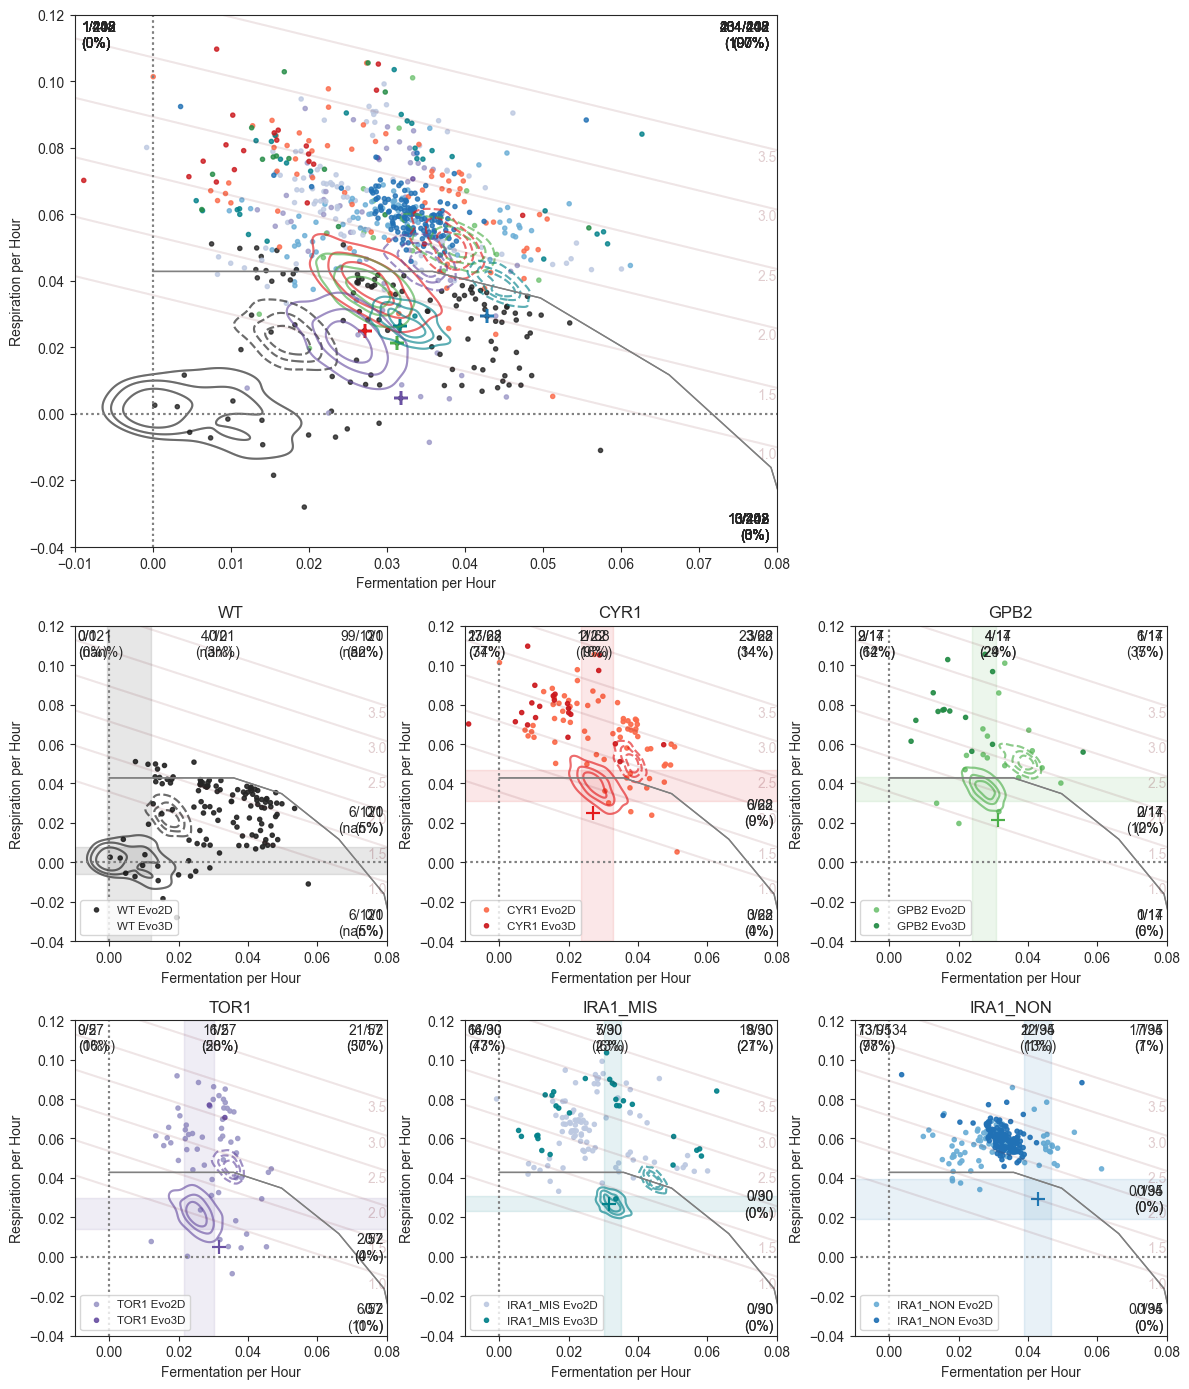

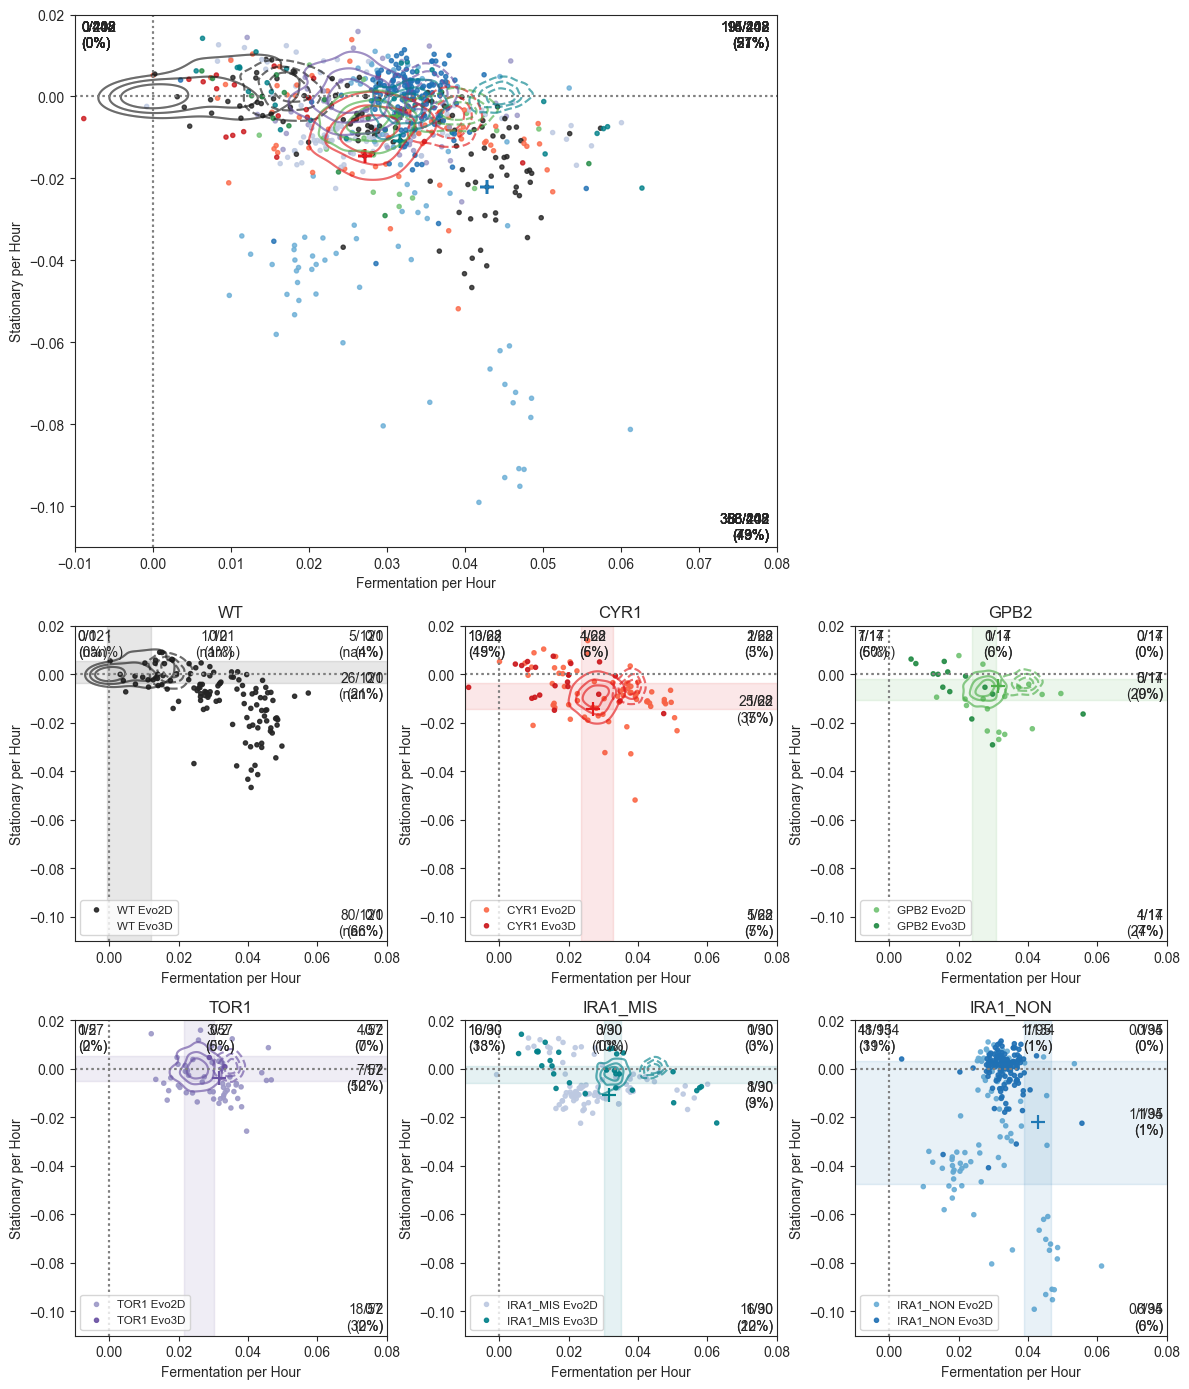

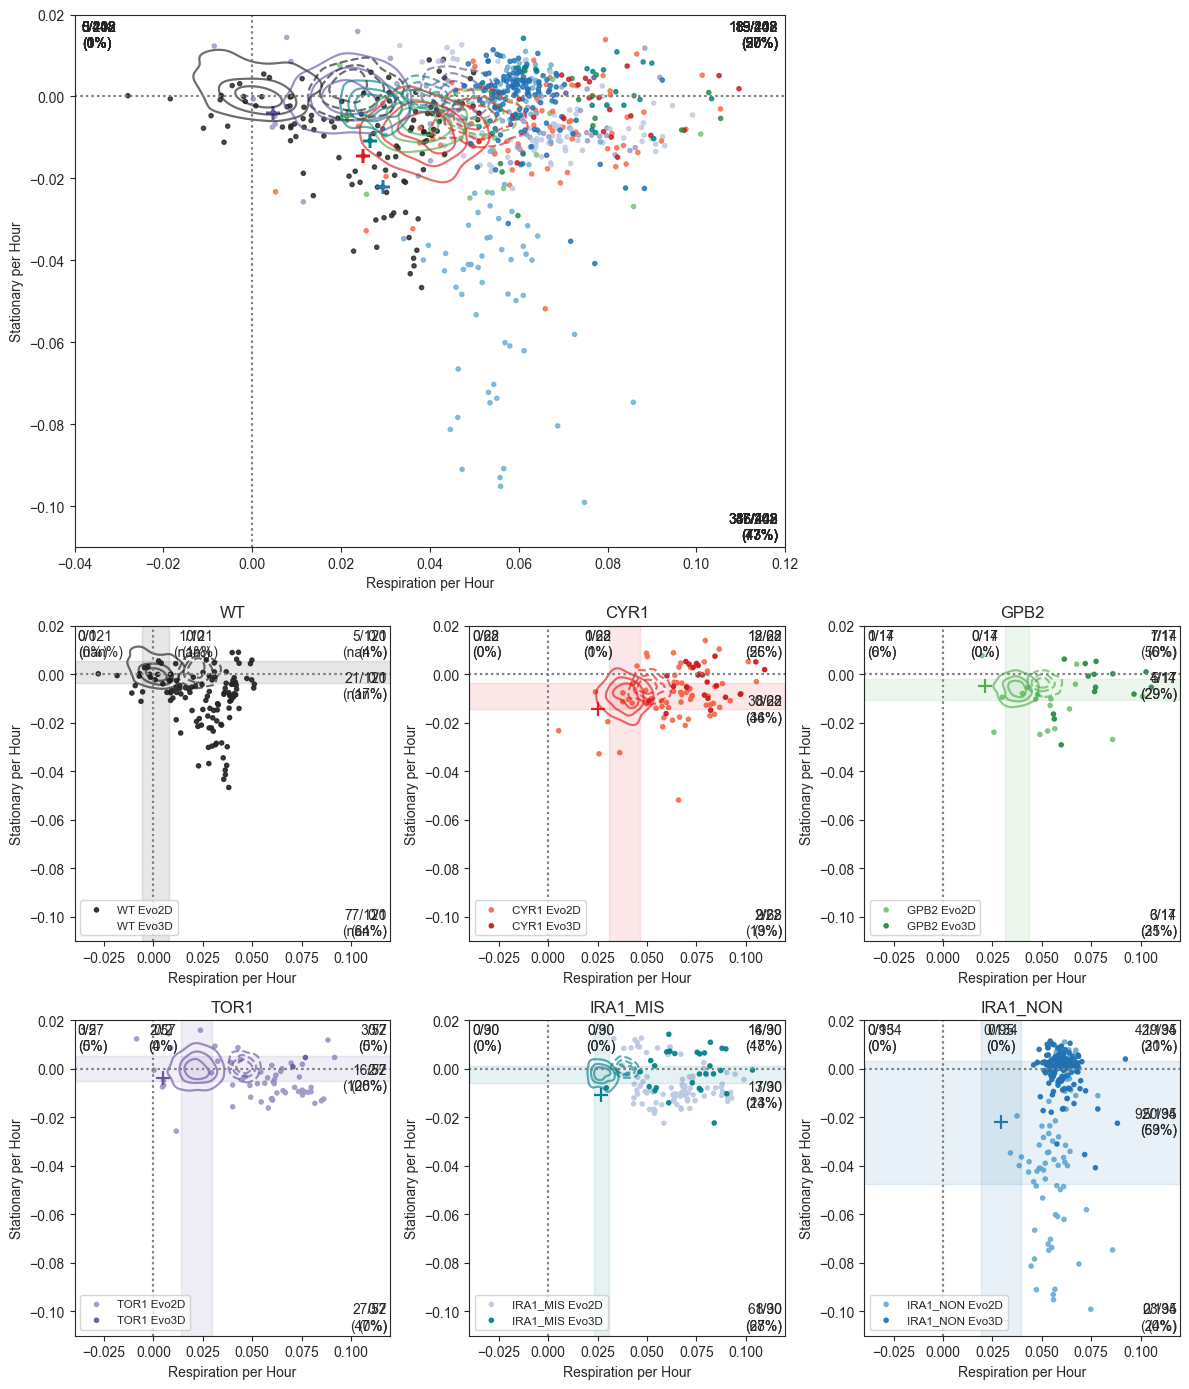

In [42]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = False


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    # publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
        ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
        fig = plt.figure(figsize=(12,14))
        outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

        inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
        inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
        for a,ancs in enumerate(ancestor_list):
            if len(ancs) > 1:
                fig.add_subplot(inner_gs1[0]) 
            else:
                fig.add_subplot(inner_gs2[a-1])
            for evo_cond in evo_cond_set:
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                

                for anc in ancs:

                    this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                    sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                    this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                    sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5

                if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
                    for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                        ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                        resps = (fitness-16*ferms)/28 # 2day = 16*F


                        norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                                vmax=np.nanmax(merged_fitness[fitness_colorby]))

                        cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 

                        plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                        plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')



                if len(ancs) > 1:
                    alpha = 0.8
                    sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[tools.anc_evo_cond_color_map[anc][evo_cond] for anc in this_data['ancestor'].values],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

                    if errorbar:
                        plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                         xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                     ms=0,linestyle='',
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')


                else:
                    alpha = 0.9
                    sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[tools.anc_evo_cond_color_map[anc][evo_cond] for anc in this_data['ancestor'].values],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

                    if errorbar:

                        plt.errorbar(x=this_data[xdata].values,y=this_data[ydata].values,
                                         xerr=2*this_data[xdata+'_error'].values,yerr=2*this_data[ydata+'_error'].values,
                                     ms=0,linestyle='',
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')

                    plt.legend(loc='lower left',fontsize='small')
                    plt.title(f'{ancs[0]}')

                for anc in ancs:

                    if anc != 'WT':

                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                        plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)

                    if len(ancs) < 2:

                        if anc != 'IRA1_NON':

                            x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                            x_error = np.nanstd(this_neutral_haploid[xdata].values)
                            y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                            y_error = np.nanstd(this_neutral_haploid[ydata].values)


                            plt.axvspan(x_mean-multiplier*x_error,
                                      x_mean+multiplier*x_error,
                                      color=tools.anc_color_map[anc],alpha=0.05)

                            plt.axhspan(y_mean-multiplier*y_error,
                                      y_mean+multiplier*y_error,
                                      color=tools.anc_color_map[anc],alpha=0.05)

                            tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,
                                                                      interesting_muts[ydata].values,
                                x_mean,y_mean,
                                x_error,y_error,
                                multiplier=multiplier)

                        else:

                            plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                                      background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                                      color=tools.anc_color_map[anc],alpha=0.05)

                            plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                                      background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                                      color=tools.anc_color_map[anc],alpha=0.05)

                            tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                        va_dict = {0:'bottom',1:'center',2:'top'}
                        ha_dict = {0:'left',1:'center',2:'right'}

                        offset = 0.01

                        for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                            if x == 1:
                                loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                            elif x == 0:
                                loc_x = x/2 + offset
                            else:
                                loc_x = x/2 - offset

                            if y == 1:
                                loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                            elif y == 0:
                                loc_y = y/2 + offset
                            else:
                                loc_y = y/2 - offset

                            plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                         ha=ha_dict[x],va=va_dict[y])

                    else:
                        tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                     0,0,0,0,
                                    multiplier=multiplier)

                        va_dict = {0:'bottom',1:'center',2:'top'}
                        ha_dict = {0:'left',1:'center',2:'right'}

                        offset = 0.01

                        for (x,y) in [(0,2),(2,0),(2,2)]:
                            if x == 1:
                                loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                            elif x == 0:
                                loc_x = x/2 + offset
                            else:
                                loc_x = x/2 - offset

                            if y == 1:
                                loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                            elif y == 0:
                                loc_y = y/2 + offset
                            else:
                                loc_y = y/2 - offset

                            plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                         x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                         ha=ha_dict[x],va=va_dict[y])


                        for anc2 in tools.rebarcoding_source_mutants.keys():
                            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc2],s=100)


        #                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
        #                                      background_mutant[xdata].values,background_mutant[ydata].values)

        #                     print(tradeoffs)
                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

                plt.xlabel(labels[xdata])
                plt.ylabel(labels[ydata])

                plt.axvline(0,color='gray',linestyle=':')
                plt.axhline(0,color='gray',linestyle=':')


        plt.tight_layout()
        if not errorbar:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only.png',bbox_inches='tight',dpi=300)
        else:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only_errorbar.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond_set}only_errorbar.png',bbox_inches='tight',dpi=300)



innovation_list = {}

total_tradeoffs_dict = {}

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    print(xdata,ydata)
    
    innovation_list[f'{xdata}_{ydata}'] = {}
    total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}
    
    
    for anc in ancestor_list[0][1:]:
        
        
        
        this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

        total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
        
        innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]
        
        
        print(anc,total_tradeoffs[:-1])
        for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

            this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

            tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)
            
#             fig = vector_plot(tradeoffs[0],anc)
#             fig.savefig(f'{home_dir}/figures/analysis/tradeoffs/vector_{xdata}_{ydata}_{anc}_{evo_set}.pdf',bbox_inches='tight')
            
            if anc == 'CYR1':
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
            else:
                total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])
            
            print(anc,evo_set,tradeoffs,total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]])
            
            
            
#             total_tradeoffs += tradeoffs 

            print(anc,evo_set,tradeoffs[:-1])

print('Improved Both')
for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    for evo_cond in ['Evo1D','Evo2D','Evo3D']:
        print(xdata,ydata,evo_cond,'improved both:',
              f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
              total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
             )
        
print('improved respiration')
resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
print('improved respiration')
resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)

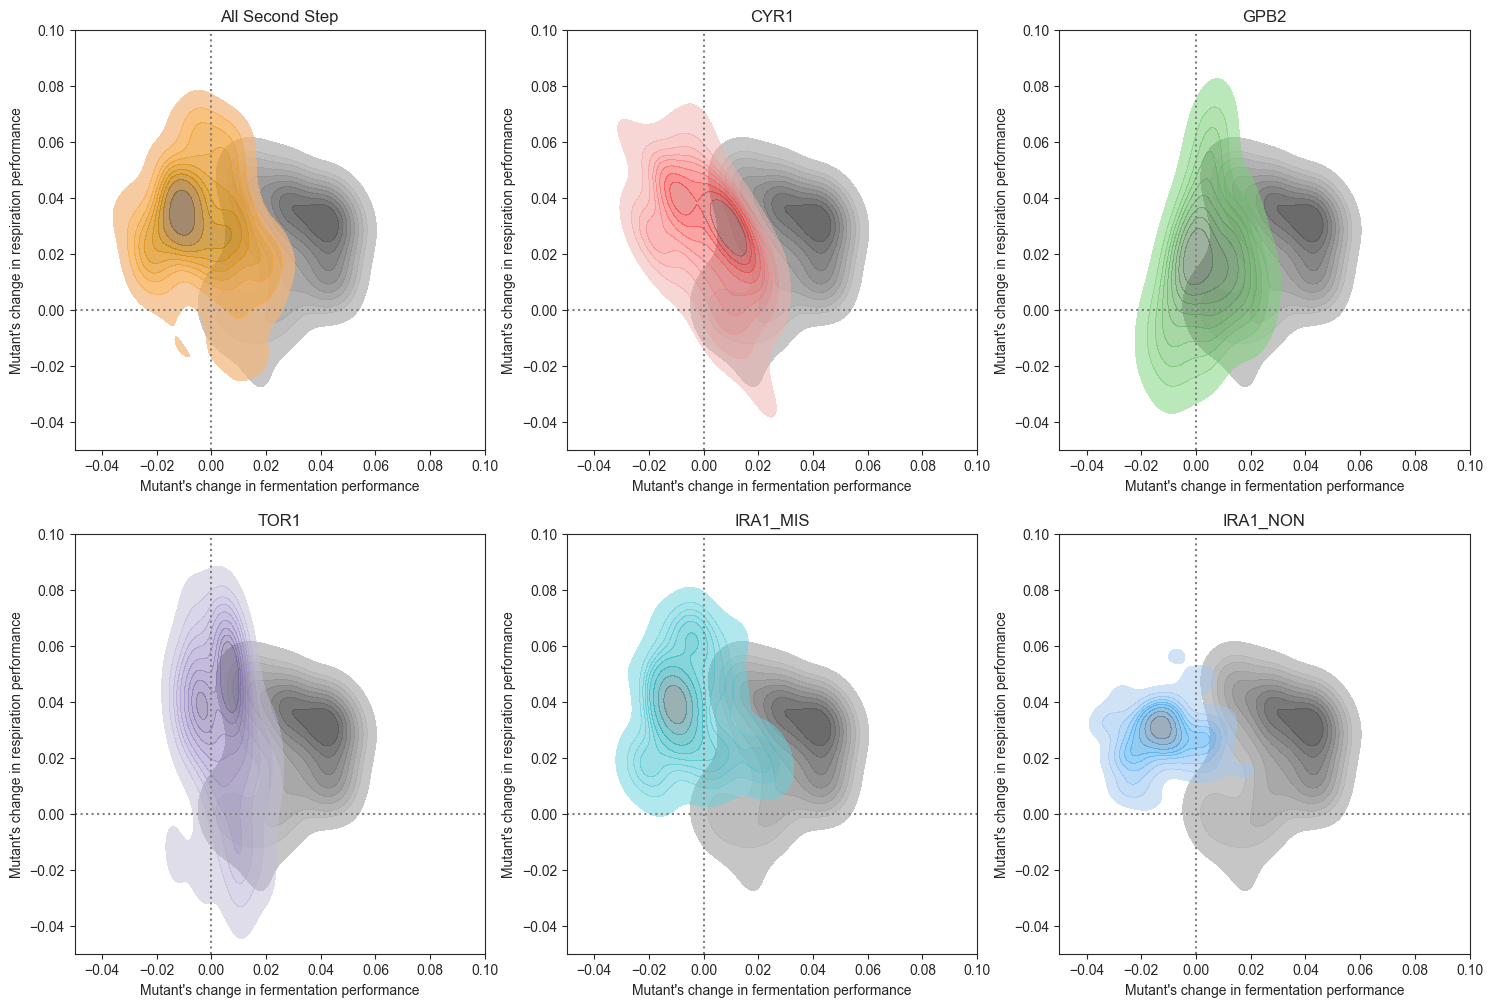

In [9]:
xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

plt.figure(figsize=(6*3,6*2))

for a,anc_list in enumerate([['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]):
    
    ax = plt.subplot(2,3,a+1)

    this_anc = noLi2019[noLi2019['ancestor'].isin(['WT'])]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    this_data = interesting_muts[interesting_muts['evolution_condition']=='Evo2D']

    sns.kdeplot(x=this_data[xdata].values,y=this_data[ydata].values,
                                color='k',fill=True,ax=ax,
                                alpha=0.9,label='First Step')

    # anc_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

    this_anc = noLi2019[noLi2019['ancestor'].isin(anc_list)]

    these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
    these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

    interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
    this_data = interesting_muts[interesting_muts['evolution_condition']=='Evo2D']

    background_x_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][xdata].values[0] for anc in anc_list}
    background_y_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][ydata].values[0] for anc in anc_list}
        
    background_x = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][xdata].values) if anc != 'IRA1_NON' else background_x_dict[anc] for anc in this_data['ancestor'].values]
    background_y = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][ydata].values) if anc != 'IRA1_NON' else background_y_dict[anc] for anc in this_data['ancestor'].values]
    
    if len(anc_list) > 1:

        sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                    color='orange',fill=True,ax=ax,
                                    alpha=0.7,label='All Second Step')
        plt.title('All Second Step')
    else:
        sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                    color=tools.anc_color_map[anc_list[0]],fill=True,ax=ax,
                                    alpha=0.5,label=anc_list[0])
        plt.title(anc_list[0])
    plt.axvline(0,color='gray',linestyle=':')
    plt.axhline(0,color='gray',linestyle=':')
    
    plt.xlim(-0.05,0.1)
    plt.ylim(-0.05,0.1)

#     plt.legend()

    plt.xlabel("Mutant's change in fermentation performance")
    plt.ylabel("Mutant's change in respiration performance")
plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/density_all2D.pdf',bbox_inches='tight')

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_16322/1870236223.py:53: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,


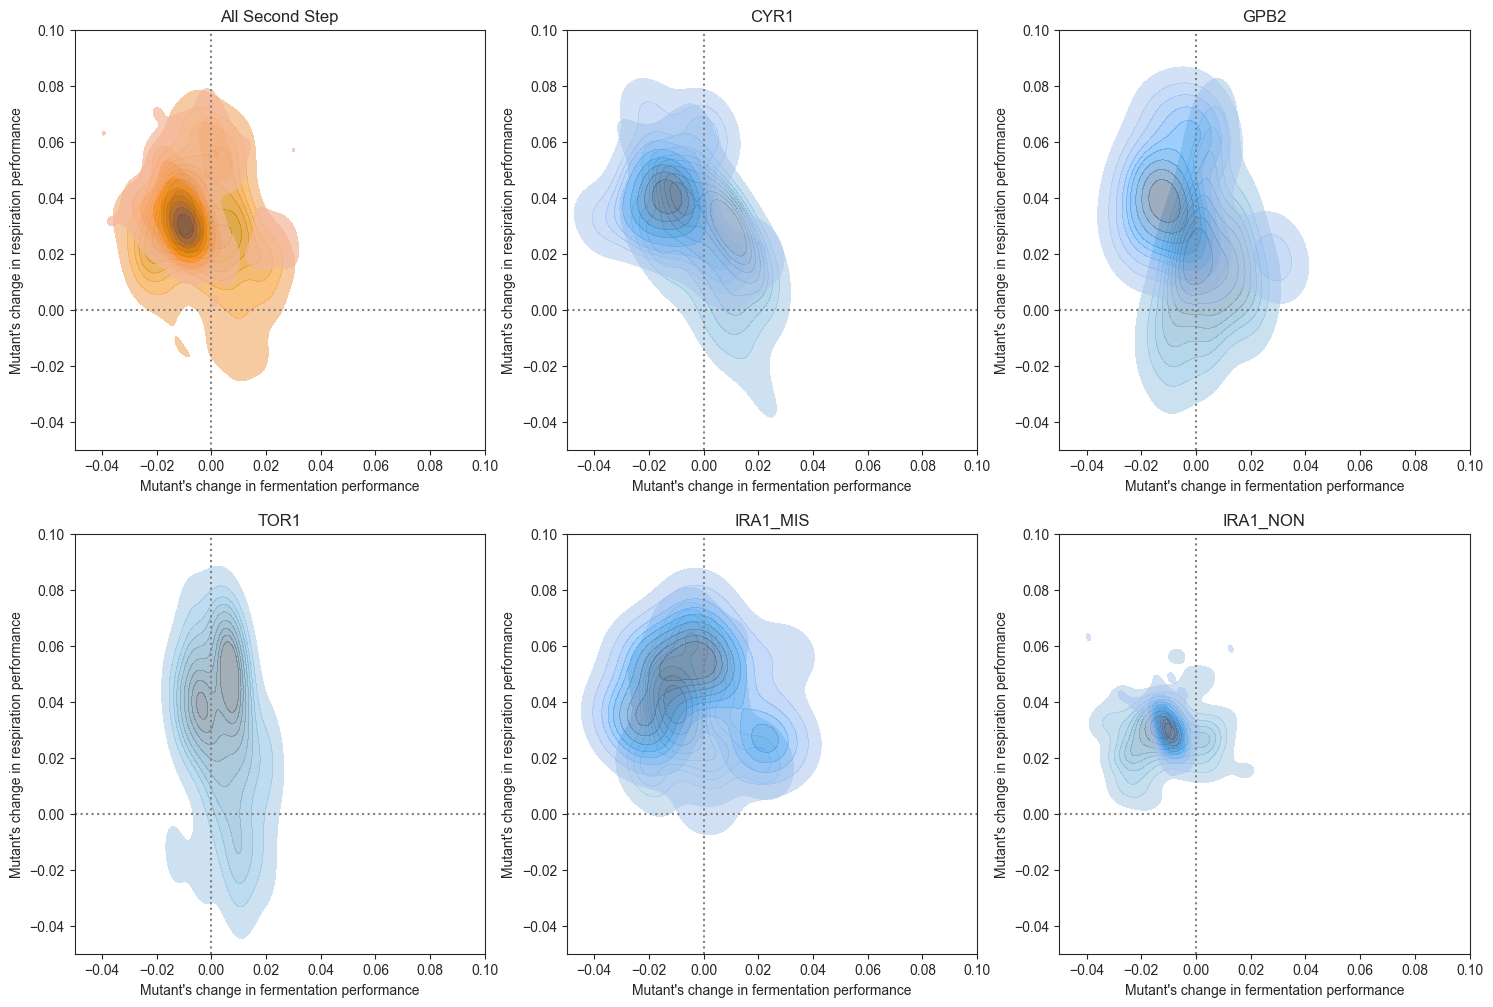

In [43]:
xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

plt.figure(figsize=(6*3,6*2))

for a,anc_list in enumerate([['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]):
    
    ax = plt.subplot(2,3,a+1)

#     this_anc = noLi2019[noLi2019['ancestor'].isin(['WT'])]

#     these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
#     these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

#     interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
#     this_data = interesting_muts[interesting_muts['evolution_condition']=='Evo2D']

#     sns.kdeplot(x=this_data[xdata].values,y=this_data[ydata].values,
#                                 color='k',fill=True,ax=ax,
#                                 alpha=0.9,label='First Step')

    # anc_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']
    
    for evo_cond in ['Evo2D','Evo3D']:

        this_anc = noLi2019[noLi2019['ancestor'].isin(anc_list)]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]

        background_x_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][xdata].values[0] for anc in anc_list}
        background_y_dict = {anc:merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]][ydata].values[0] for anc in anc_list}

        background_x = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][xdata].values) if anc != 'IRA1_NON' else background_x_dict[anc] for anc in this_data['ancestor'].values]
        background_y = [np.nanmean(this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')][ydata].values) if anc != 'IRA1_NON' else background_y_dict[anc] for anc in this_data['ancestor'].values]

        if len(anc_list) > 1:
            if evo_cond == 'Evo2D':
                sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                        color='k',fill=True,ax=ax,
                                        alpha=0.7,label='All Second Step')
            else:
                sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                        color='orange',fill=True,ax=ax,
                                        alpha=0.7,label='All Second Step')
            plt.title('All Second Step')
        else:
            if evo_cond == 'Evo2D'
                sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                            color='k',fill=True,ax=ax,
                                            alpha=0.5,label=anc_list[0])
            else:
                sns.kdeplot(x=this_data[xdata].values-background_x,y=this_data[ydata].values-background_y,
                                            color=tools.anc_color_map[anc],fill=True,ax=ax,
                                            alpha=0.5,label=anc_list[0])
            plt.title(anc_list[0])
    plt.axvline(0,color='gray',linestyle=':')
    plt.axhline(0,color='gray',linestyle=':')
    
    plt.xlim(-0.05,0.1)
    plt.ylim(-0.05,0.1)

#     plt.legend()

    plt.xlabel("Mutant's change in fermentation performance")
    plt.ylabel("Mutant's change in respiration performance")
plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/density_2Dvs3D.pdf',bbox_inches='tight')

In [9]:
xdata = 'FerPerHour'
ydata = 'ResPerHour'
this_anc = noLi2019[noLi2019['ancestor'].isin(['WT'])]

these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

wt_tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 0,0,0,0,
                                multiplier=multiplier)

In [10]:
wt_tradeoffs

[[0, 0, 0], [0, 0, 0], [14, 0, 162]]

In [40]:

for multiplier in [0,1]:
    print(f'Multiplier = {multiplier}')
    total_tradeoffs_dict = {}

    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        print(xdata,ydata)

        innovation_list[f'{xdata}_{ydata}'] = {}
        total_tradeoffs_dict[f'{xdata}_{ydata}'] = {}


        for anc in ancestor_list[0][1:]:

            this_anc = noLi2019[noLi2019['ancestor'].isin([anc])]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
            this_neutral_haploid = this_anc[this_anc['barcode'].isin(list(these_neutral_haploids))]
            
            if anc != 'IRA1_NON':
            
                x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                x_error = np.nanstd(this_neutral_haploid[xdata].values)
                y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                y_error = np.nanstd(this_neutral_haploid[ydata].values)
                
            else:
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
                x_mean = background_mutant[xdata].values
                x_error = background_mutant[xdata+'_error'].values
                y_mean = background_mutant[ydata].values
                y_error = background_mutant[ydata+'_error'].values

            total_tradeoffs = count_tradeoffs(interesting_muts[xdata].values,
                                            interesting_muts[ydata].values,
                                            x_mean,y_mean,
                                            x_error,y_error,
                                            multiplier=multiplier)


            innovation_list[f'{xdata}_{ydata}'][f'{anc}'] = interesting_muts['barcode'].values[total_tradeoffs[-1]]

            print(anc,total_tradeoffs[:-1])
            for evo_set in [['Evo1D'],['Evo2D'],['Evo3D']]:

                this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_set)]

                tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
                                 background_mutant[xdata].values,background_mutant[ydata].values,
                                background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                                multiplier=multiplier)

                if anc == 'CYR1':
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] = np.asarray(tradeoffs[0])
                else:
                    total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_set[0]] += np.asarray(tradeoffs[0])


                print(anc,evo_set,tradeoffs[:-1])

    print('Improved Both')
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        for evo_cond in ['Evo1D','Evo2D','Evo3D']:
            print(xdata,ydata,evo_cond,'improved both:',
                  f"{total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]}/{np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])}",
                  total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond][2][2]/np.sum(total_tradeoffs_dict[f'{xdata}_{ydata}'][evo_cond])
                 )

    print('improved respiration')
    resp_up = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][:,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][:,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up}/{all_2_3}',resp_up/all_2_3)
    print('improved respiration at cost of fermentation')
    resp_up_fer_down = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'][0,2])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'][0,2])
    all_2_3 = np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo2D'])+np.sum(total_tradeoffs_dict[f'FerPerHour_ResPerHour']['Evo3D'])
    print(f'{resp_up_fer_down}/{all_2_3}',resp_up_fer_down/all_2_3)


Multiplier = 0
FerPerHour ResPerHour
CYR1 ([[0, 0, 48], [0, 0, 0], [9, 0, 39]], 96)
CYR1 ['Evo1D'] ([[0, 0, 2], [0, 0, 0], [2, 0, 2]], 6)
CYR1 ['Evo2D'] ([[1, 0, 57], [0, 0, 0], [2, 0, 8]], 68)
CYR1 ['Evo3D'] ([[0, 0, 21], [0, 0, 0], [0, 0, 1]], 22)
GPB2 ([[2, 0, 16], [0, 0, 0], [5, 0, 19]], 42)
GPB2 ['Evo1D'] ([[1, 0, 7], [0, 0, 0], [2, 0, 1]], 11)
GPB2 ['Evo2D'] ([[2, 0, 13], [0, 0, 0], [0, 0, 2]], 17)
GPB2 ['Evo3D'] ([[0, 0, 13], [0, 0, 0], [0, 0, 1]], 14)
TOR1 ([[2, 0, 19], [0, 0, 0], [7, 0, 43]], 71)
TOR1 ['Evo1D'] ([[1, 0, 8], [0, 0, 0], [0, 0, 3]], 12)
TOR1 ['Evo2D'] ([[9, 0, 44], [0, 0, 0], [1, 0, 3]], 57)
TOR1 ['Evo3D'] ([[0, 0, 2], [0, 0, 0], [0, 0, 0]], 2)
IRA1_MIS ([[4, 0, 85], [0, 0, 0], [3, 0, 48]], 140)
IRA1_MIS ['Evo1D'] ([[8, 0, 7], [0, 0, 0], [2, 0, 3]], 20)
IRA1_MIS ['Evo2D'] ([[0, 0, 82], [0, 0, 0], [0, 0, 8]], 90)
IRA1_MIS ['Evo3D'] ([[0, 0, 24], [0, 0, 0], [0, 0, 6]], 30)
IRA1_NON ([[0, 0, 211], [0, 0, 0], [0, 0, 30]], 241)
IRA1_NON ['Evo1D'] ([[0, 0, 0], [0, 0, 0

In [27]:
merged_fitness[merged_fitness['barcode'].isin(innovation_list['FerPerHour_ResPerHour'])][['barcode','gene','ancestor','evolution_condition','class_new','all_mutations_verbose']].to_csv(f'{home_dir}/data/intermediate/innovators_FerRes.csv')

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_16322/1110214073.py:185: RuntimeWarning: invalid value encountered in long_scalars
  plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_16322/1110214073.py:185: RuntimeWarning: invalid value encountered in long_scalars
  plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-

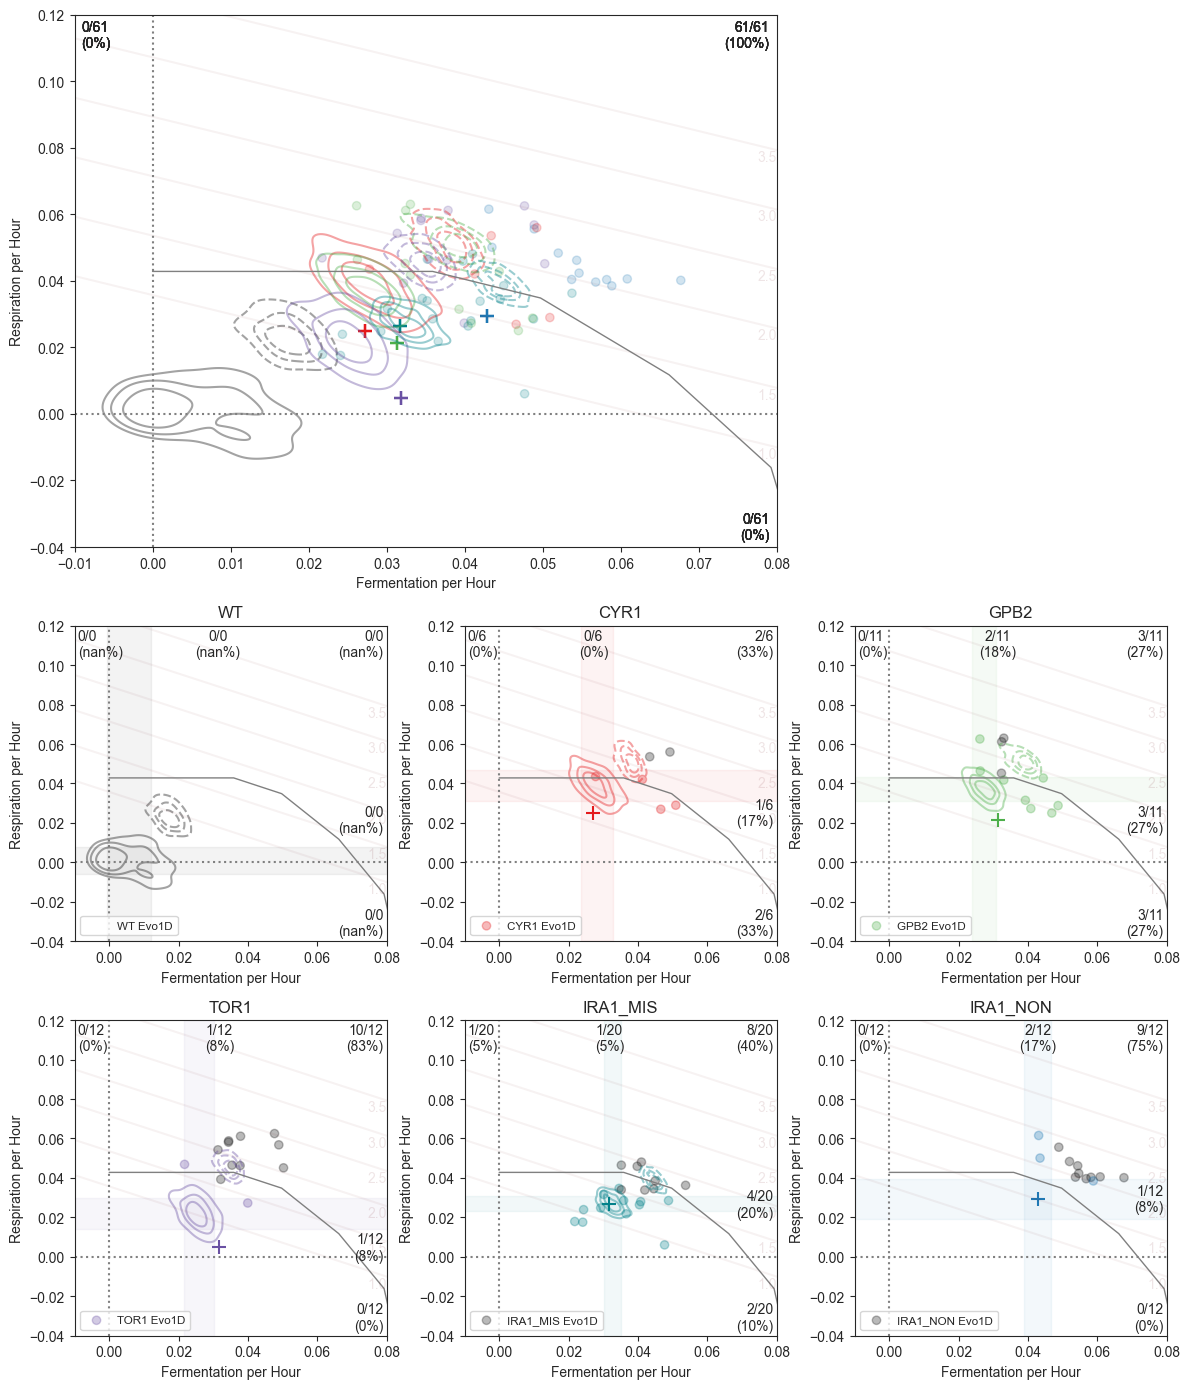

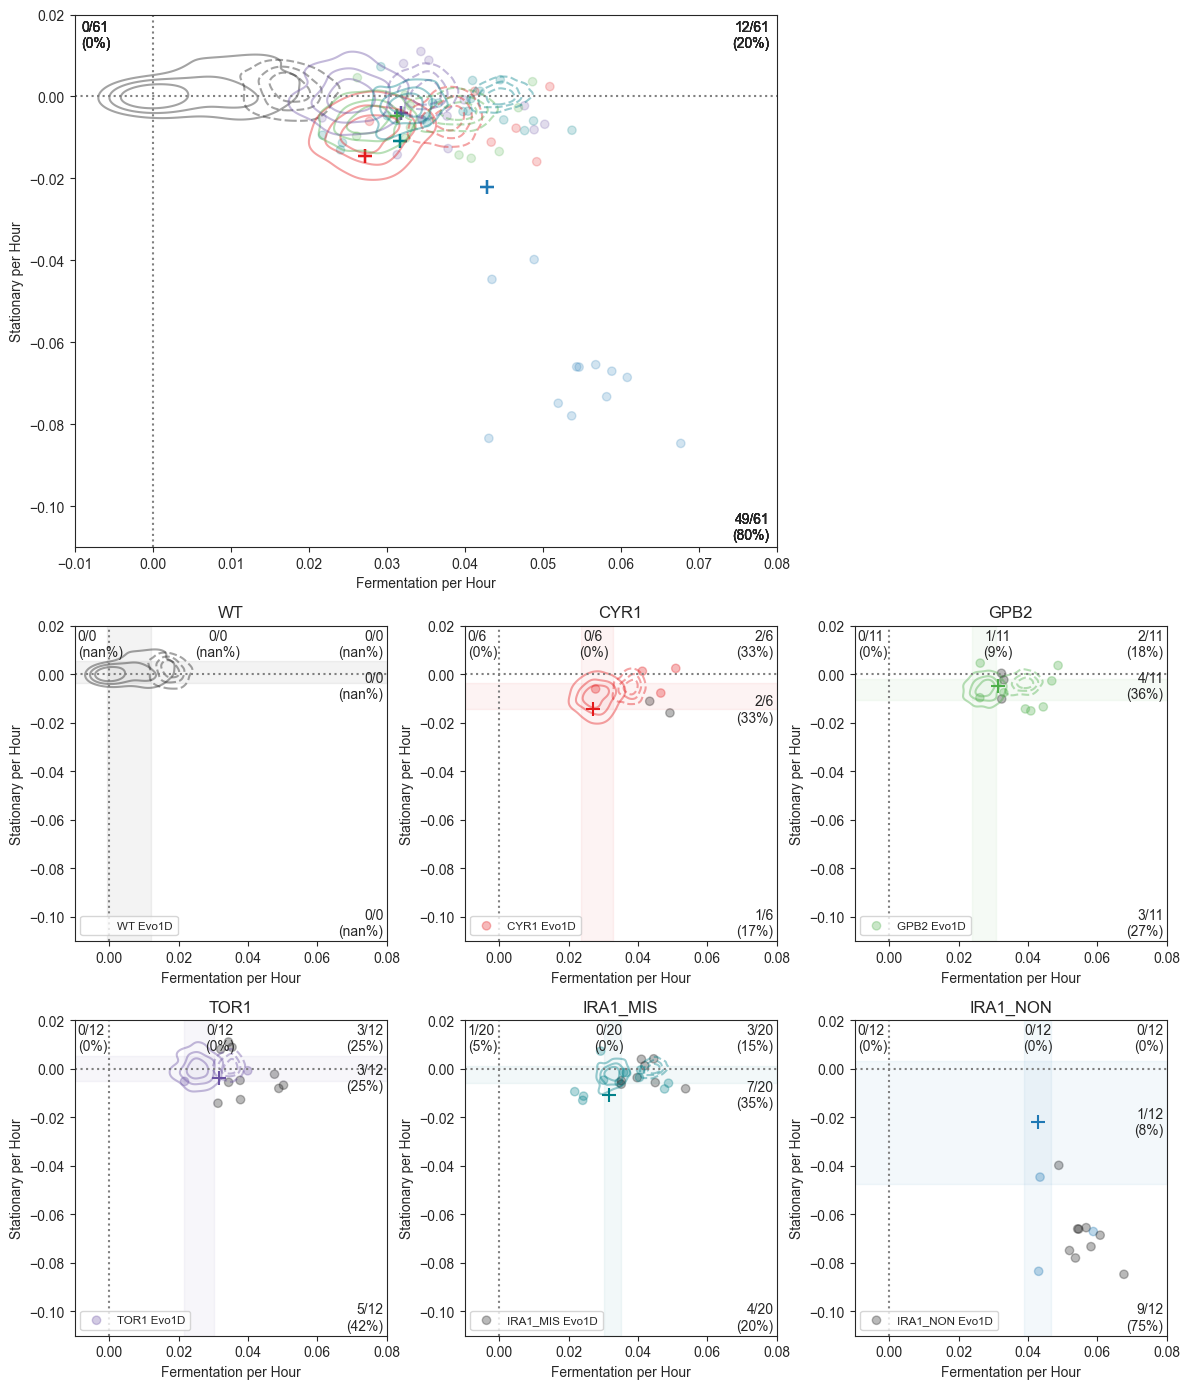

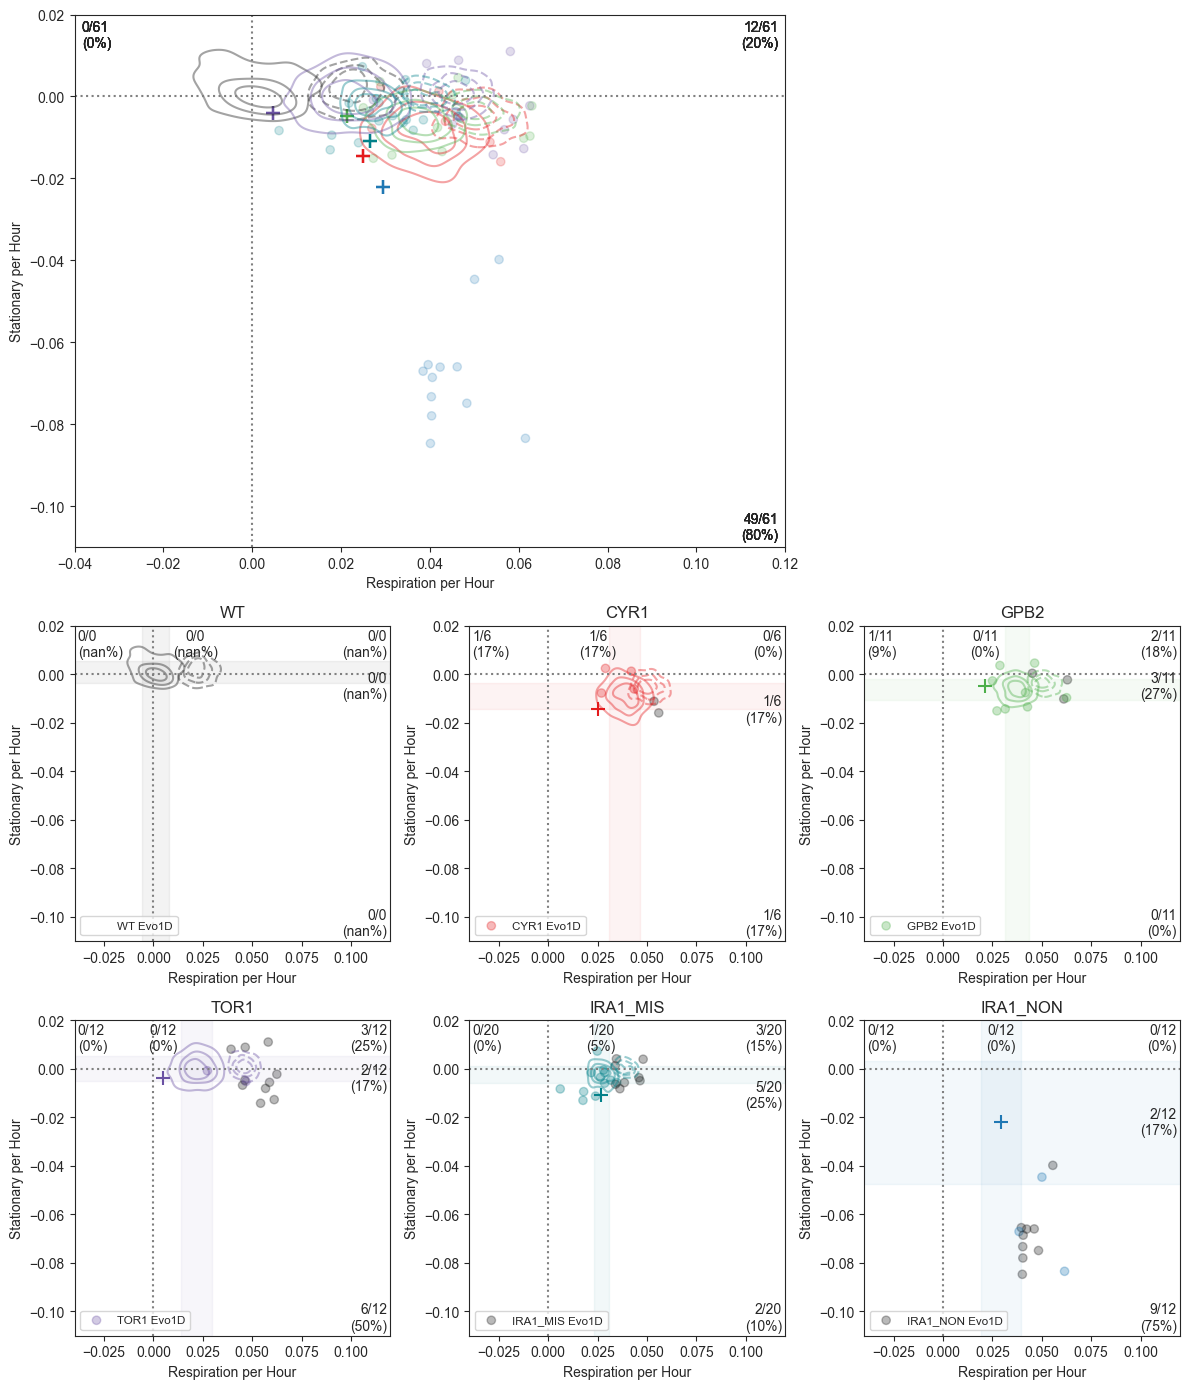

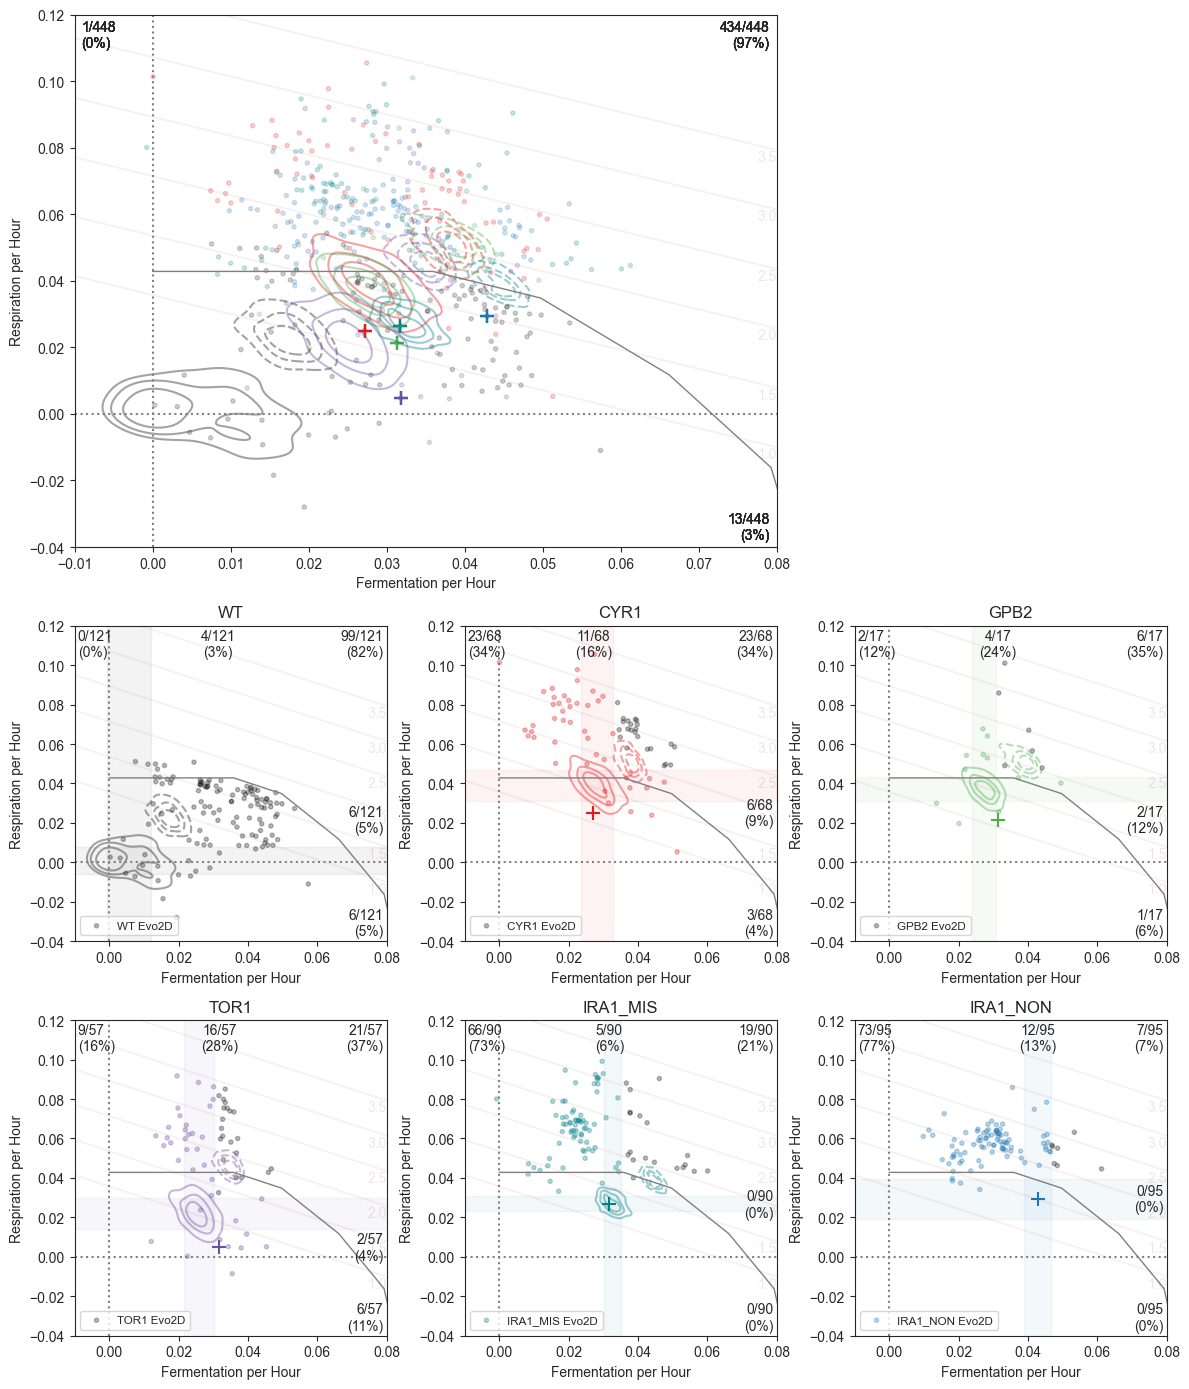

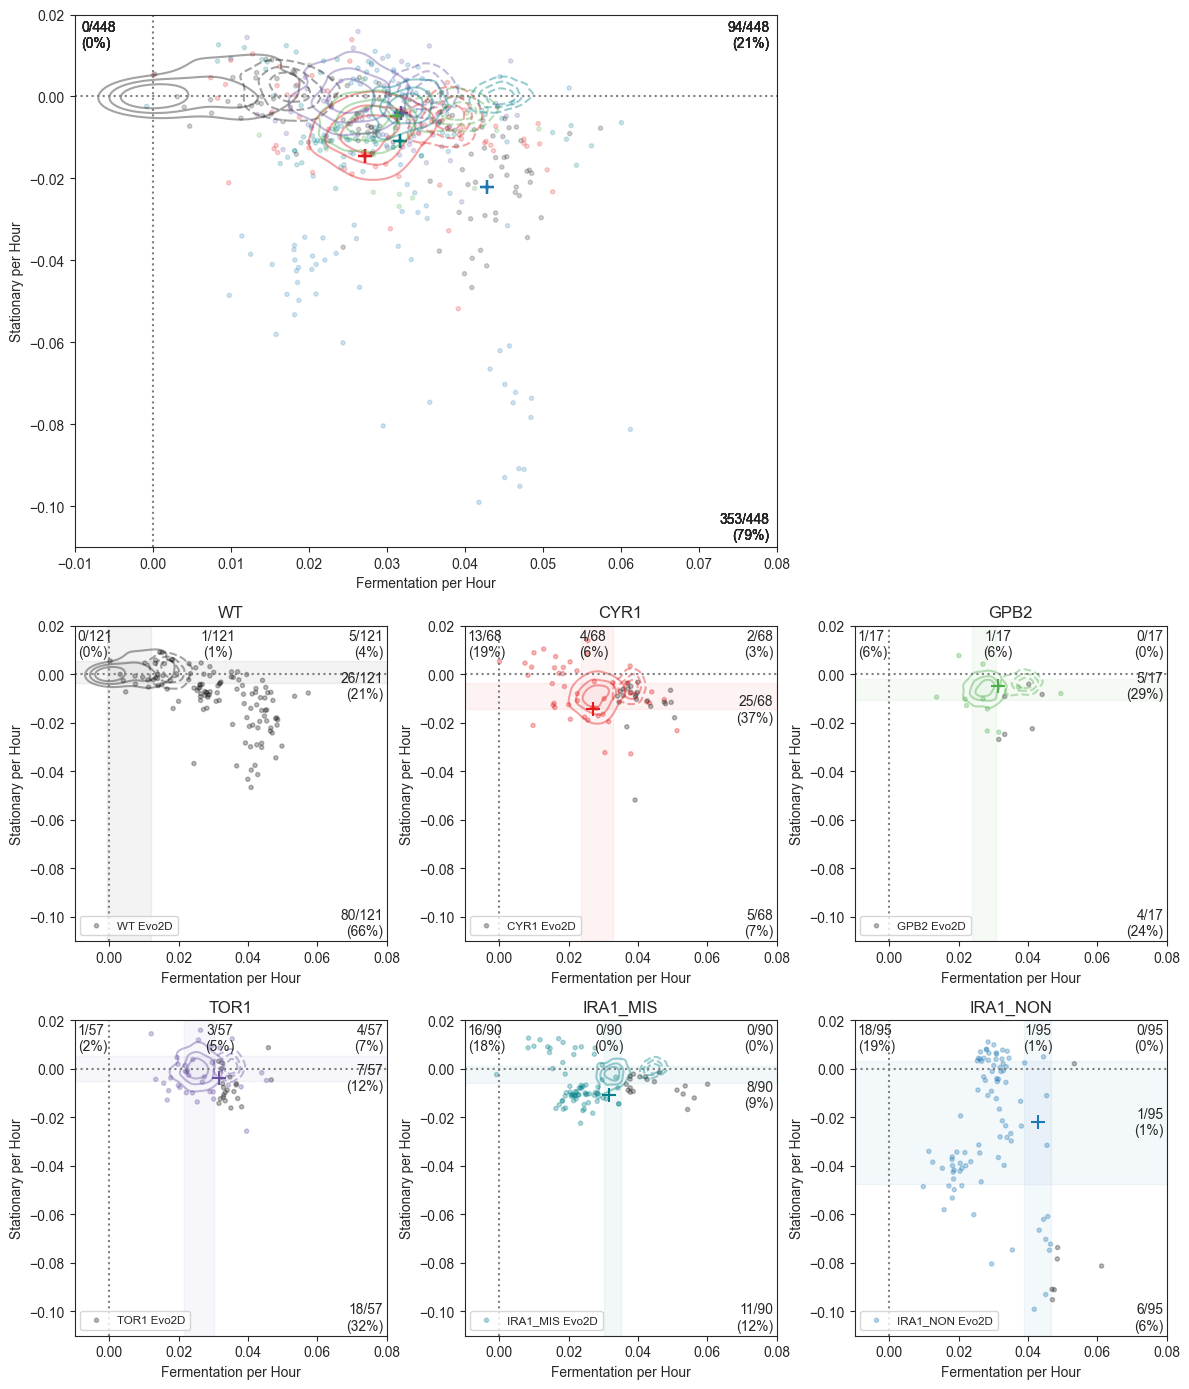

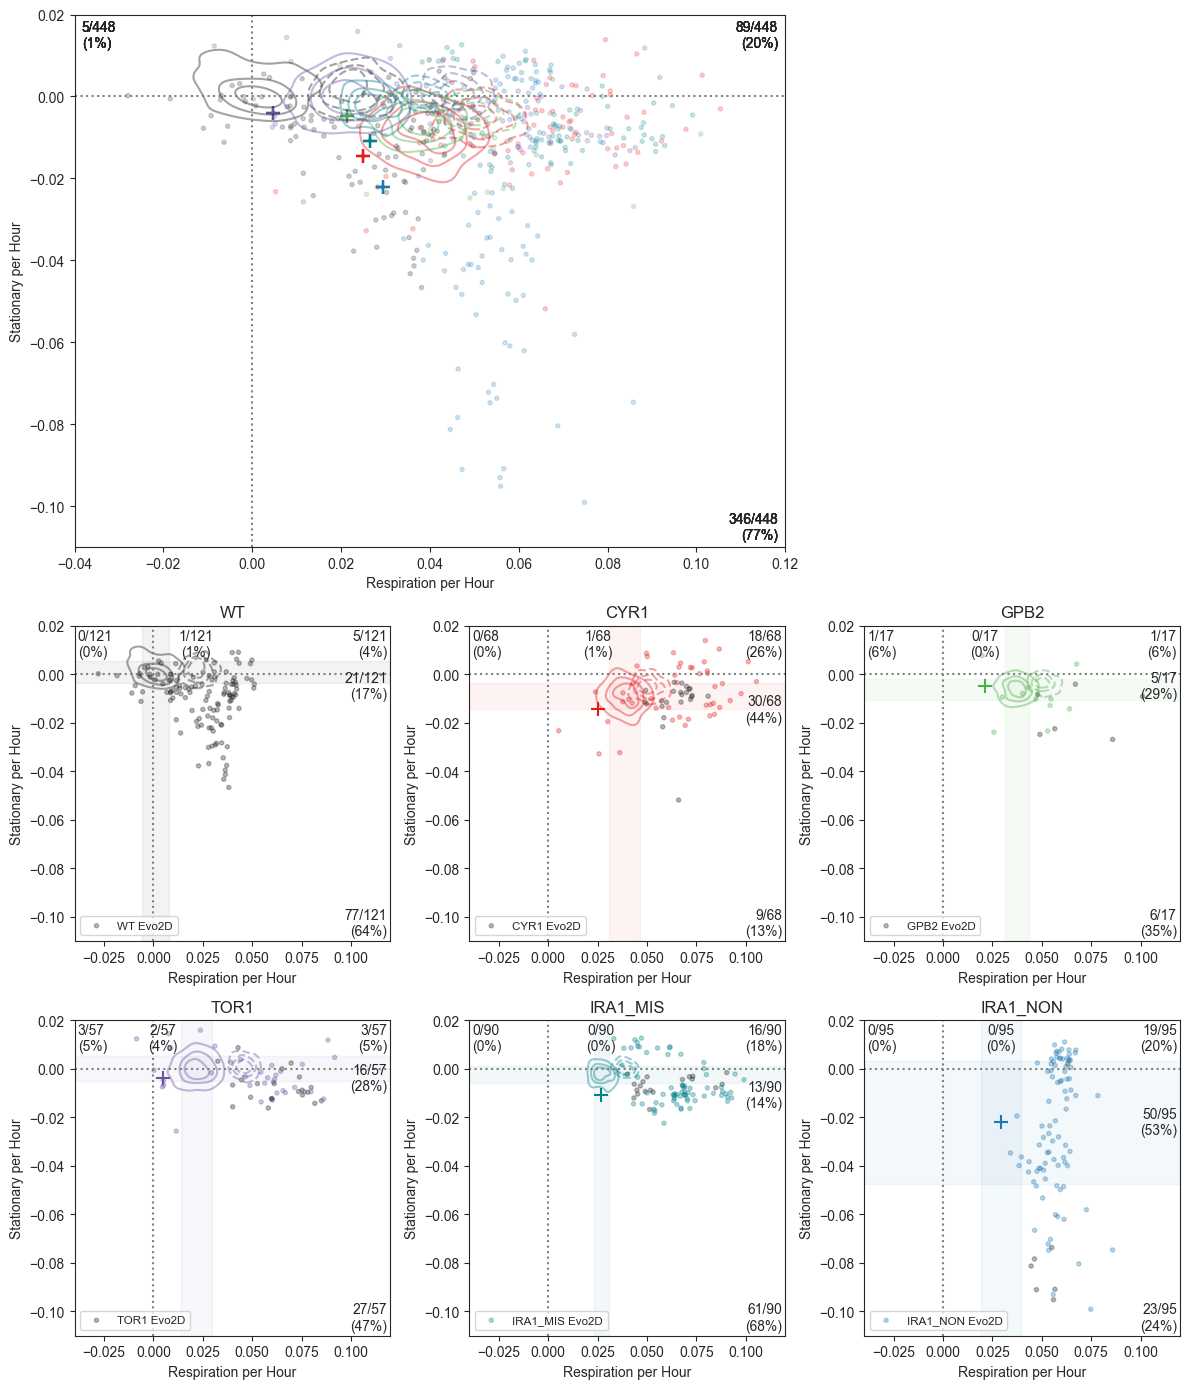

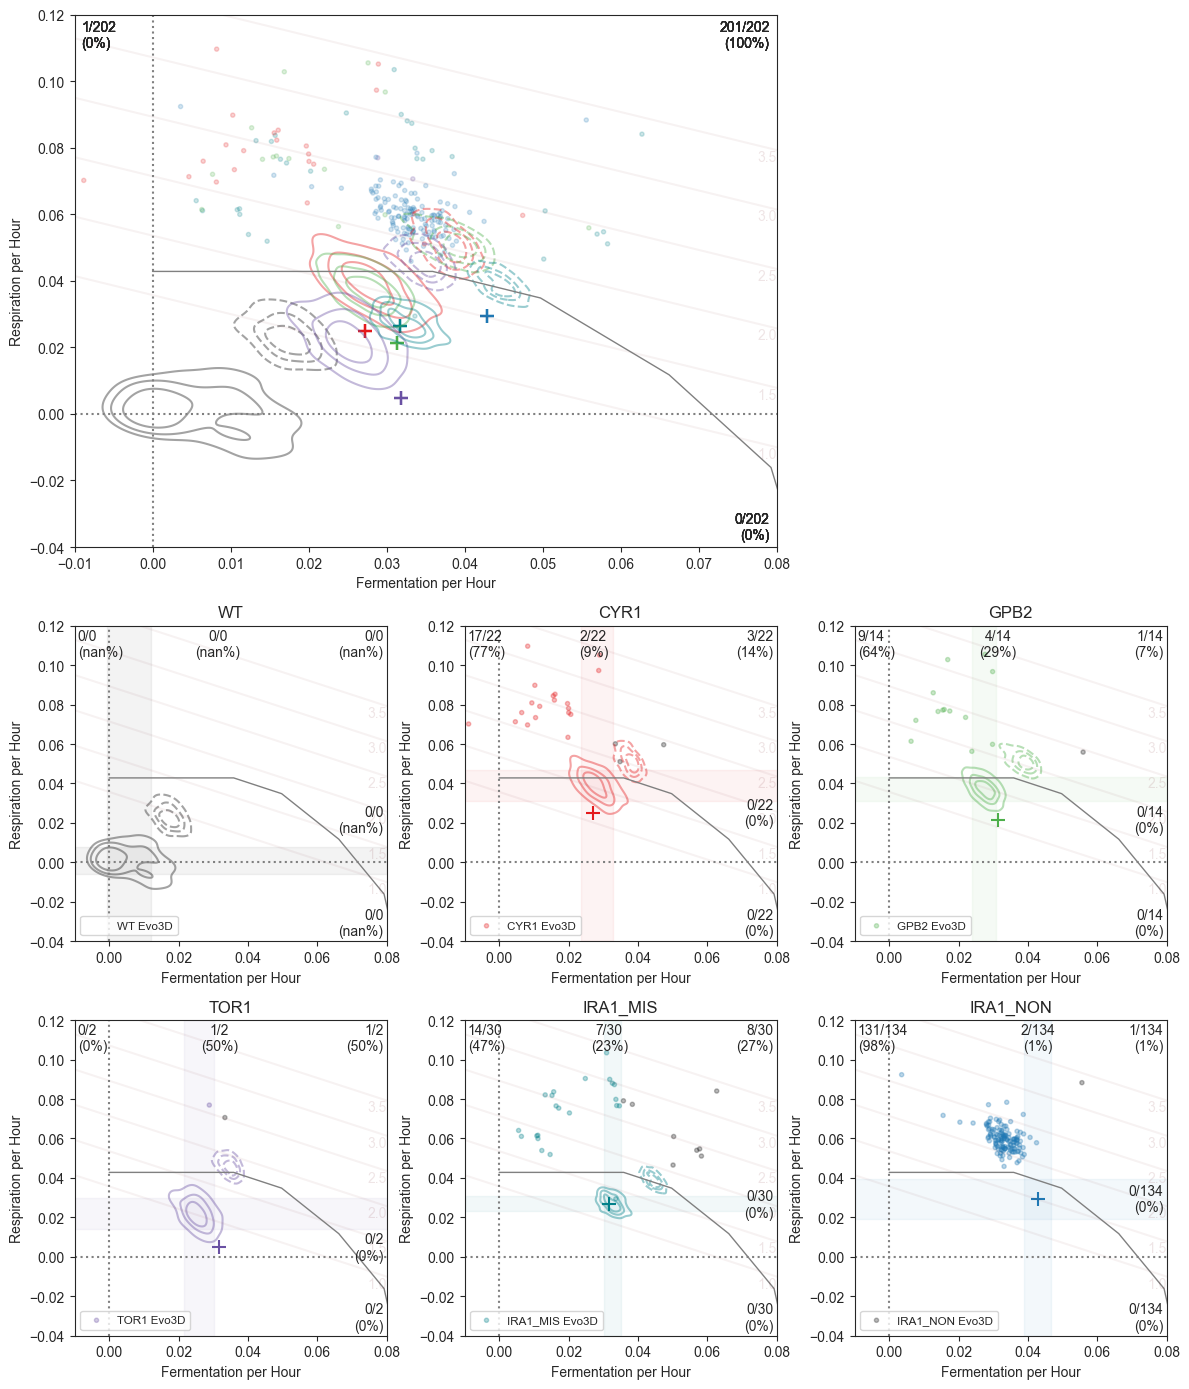

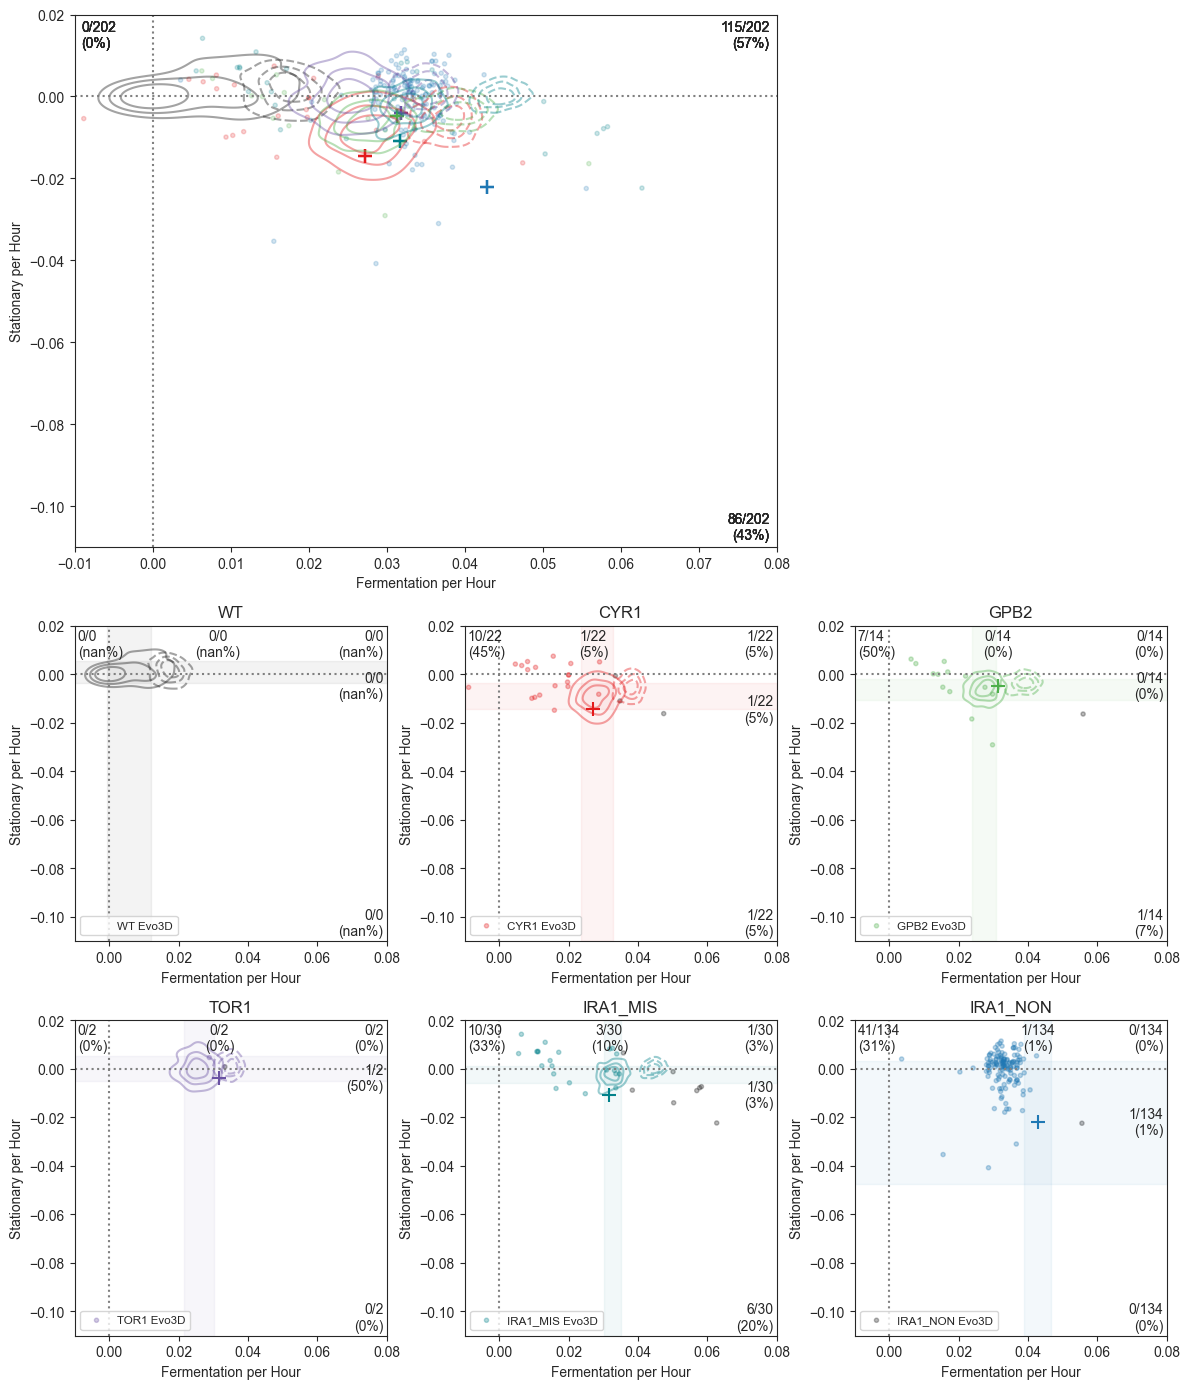

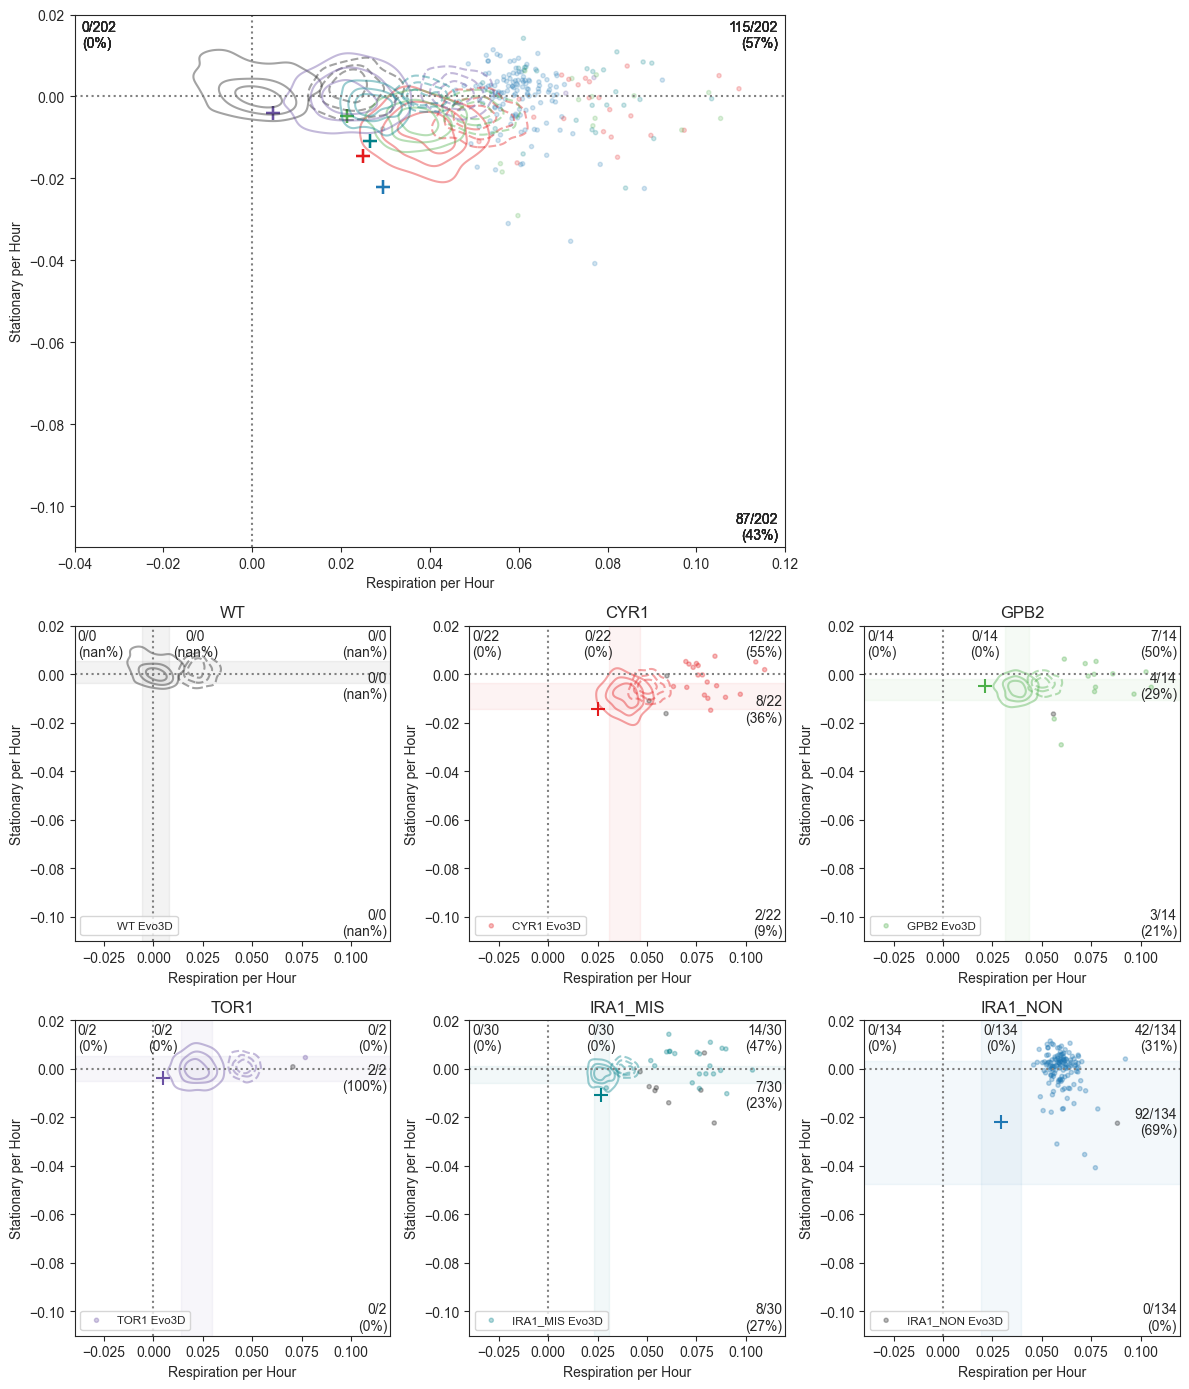

In [30]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = False


# cutoff for standard deviation
multiplier = 1.0

# innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

for evo_cond in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
    # publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
        ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
        fig = plt.figure(figsize=(12,14))
        outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

        inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,1,1],wspace=0.25,hspace=0.25)
        inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)


        for a,ancs in enumerate(ancestor_list):

            this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
            if len(ancs) > 1:
                fig.add_subplot(inner_gs1[0]) 
            else:
                fig.add_subplot(inner_gs2[a-1])

            for anc in ancs:

                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
                
            interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5
            
            if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
                for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                    ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                    resps = (fitness-16*ferms)/28 # 2day = 16*F


                    norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                            vmax=np.nanmax(merged_fitness[fitness_colorby]))

                    cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 

                    plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                    plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')



            if len(ancs) > 1:
                alpha = 0.2
                sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                            
                            alpha=alpha,
                            marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                     
            else:
                alpha = 0.3
                if anc!='WT':
                    sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[tools.anc_color_map[anc] if bc not in innovation_list['FerPerHour_ResPerHour'][anc] else 'k' for bc,anc in zip(this_data['barcode'].values,this_data['ancestor'].values)],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                else:
                    sc = plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=[tools.anc_color_map[anc] for anc in this_data['ancestor'].values],
                                alpha=alpha,
                                marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')

            for anc in ancs:

                if anc != 'WT':

                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc],s=100)

                if len(ancs) < 2:

                    if anc != 'IRA1_NON':

                        x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                        x_error = np.nanstd(this_neutral_haploid[xdata].values)
                        y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                        y_error = np.nanstd(this_neutral_haploid[ydata].values)


                        plt.axvspan(x_mean-multiplier*x_error,
                                  x_mean+multiplier*x_error,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        plt.axhspan(y_mean-multiplier*y_error,
                                  y_mean+multiplier*y_error,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,
                                                                  interesting_muts[ydata].values,
                            x_mean,y_mean,
                            x_error,y_error,
                            multiplier=multiplier)

                    else:

                        plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                                  background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                                  background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                                  color=tools.anc_color_map[anc],alpha=0.05)

                        tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                             background_mutant[xdata].values,background_mutant[ydata].values,
                            background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                            multiplier=multiplier)

                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}

                    offset = 0.01

                    for (x,y) in [(0,2),(2,0),(1,2),(2,1),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset

                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset

                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])

                else:
                    tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                                 0,0,0,0,
                                multiplier=multiplier)

                    va_dict = {0:'bottom',1:'center',2:'top'}
                    ha_dict = {0:'left',1:'center',2:'right'}

                    offset = 0.01

                    for (x,y) in [(0,2),(2,0),(2,2)]:
                        if x == 1:
                            loc_x = (background_mutant[xdata].values[0]-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                        elif x == 0:
                            loc_x = x/2 + offset
                        else:
                            loc_x = x/2 - offset

                        if y == 1:
                            loc_y = (background_mutant[ydata].values[0]-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                        elif y == 0:
                            loc_y = y/2 + offset
                        else:
                            loc_y = y/2 - offset

                        plt.text(s=f'{tradeoffs[x][y]}/{n_obs}\n({tradeoffs[x][y]/n_obs:.0%})',
                                     x=loc_x,y=loc_y,transform=plt.gca().transAxes,
                                     ha=ha_dict[x],va=va_dict[y])


                    for anc2 in tools.rebarcoding_source_mutants.keys():
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='+',color=tools.anc_color_map[anc2],s=100)


    #                     tradeoffs = count_tradeoffs(this_data[xdata].values,this_data[ydata].values,
    #                                      background_mutant[xdata].values,background_mutant[ydata].values)

    #                     print(tradeoffs)
            if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

            plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
            plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

            plt.xlabel(labels[xdata])
            plt.ylabel(labels[ydata])
            
            plt.axvline(0,color='gray',linestyle=':')
            plt.axhline(0,color='gray',linestyle=':')


        plt.tight_layout()
        if not errorbar:
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_innovationcolor.pdf',bbox_inches='tight')
            plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_improvement_{evo_cond}only_innovationcolor.png',bbox_inches='tight',dpi=300)

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_16322/4205254319.py:145: RuntimeWarning: Mean of empty slice
  x_mean = np.nanmean(this_neutral_haploid[xdata].values)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_16322/4205254319.py:147: RuntimeWarning: Mean of empty slice
  y_mean = np.nanmean(this_neutral_haploid[ydata].values)
/Users/grantkinsler/Library/Python/3.8/lib/python/site-packages/matplotlib/patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipyker

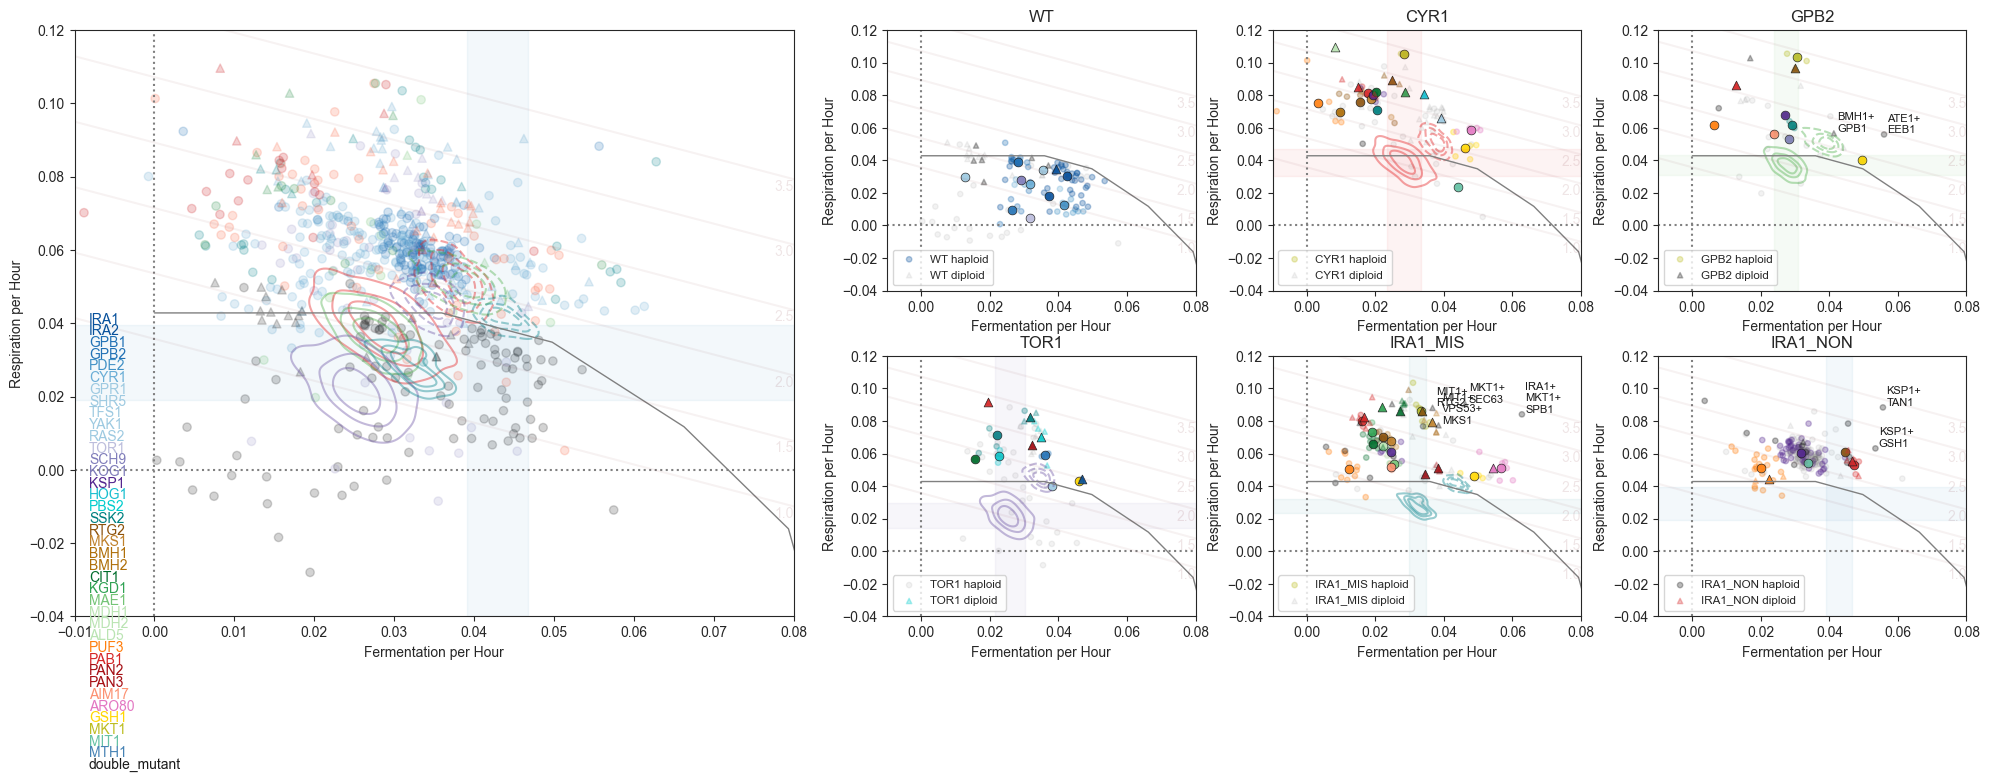

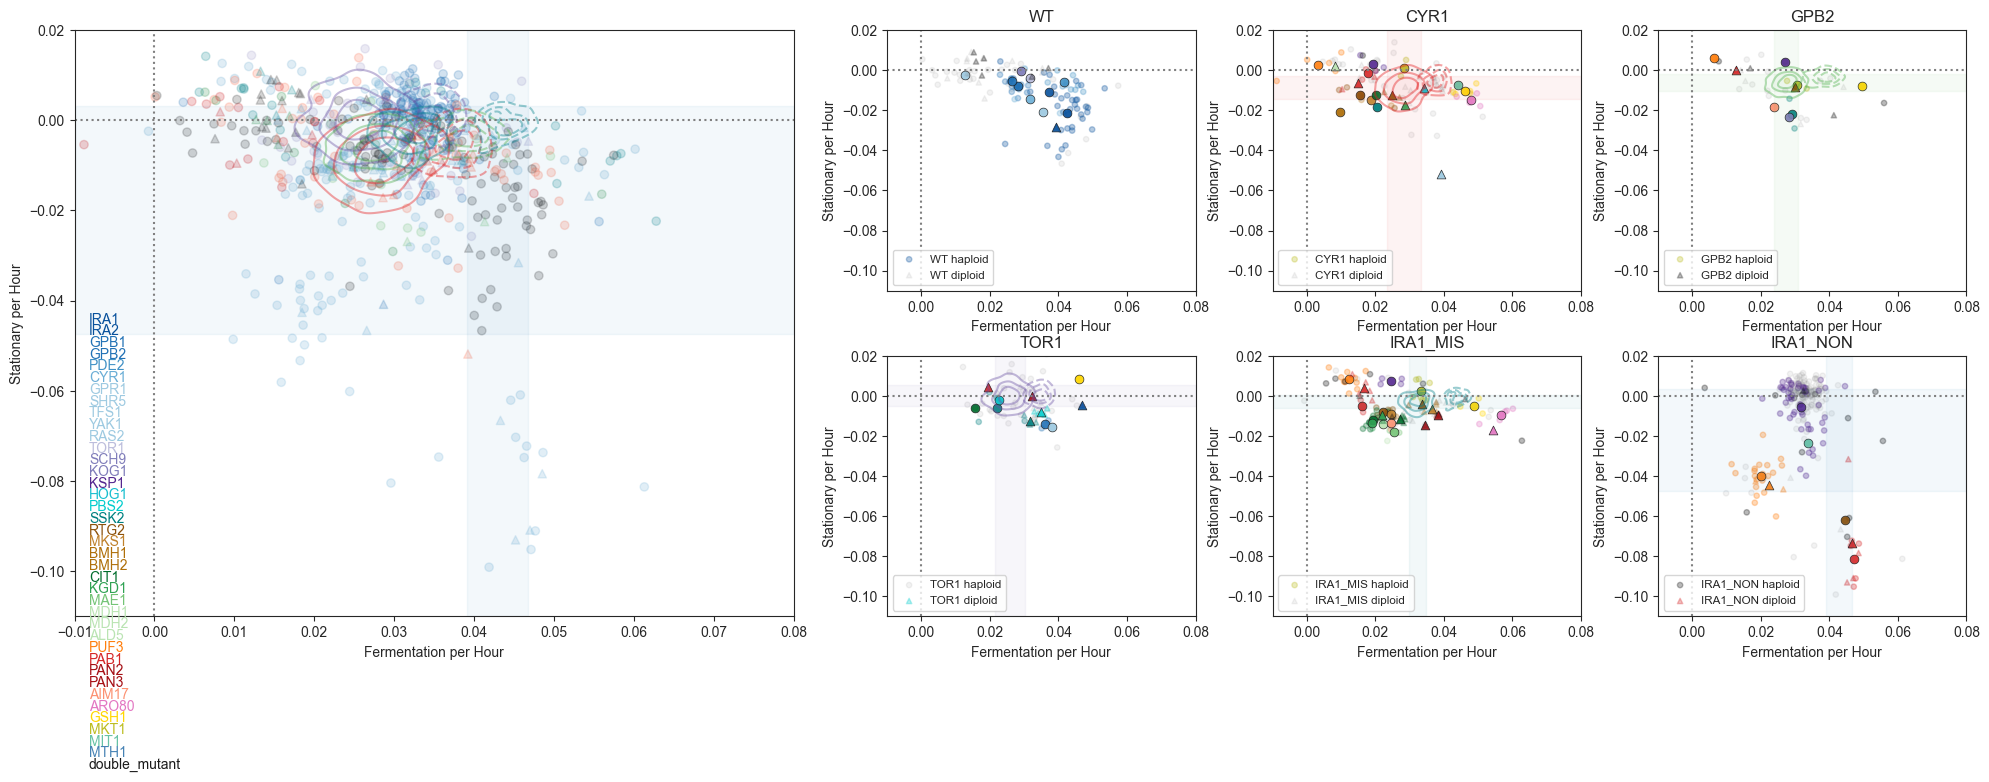

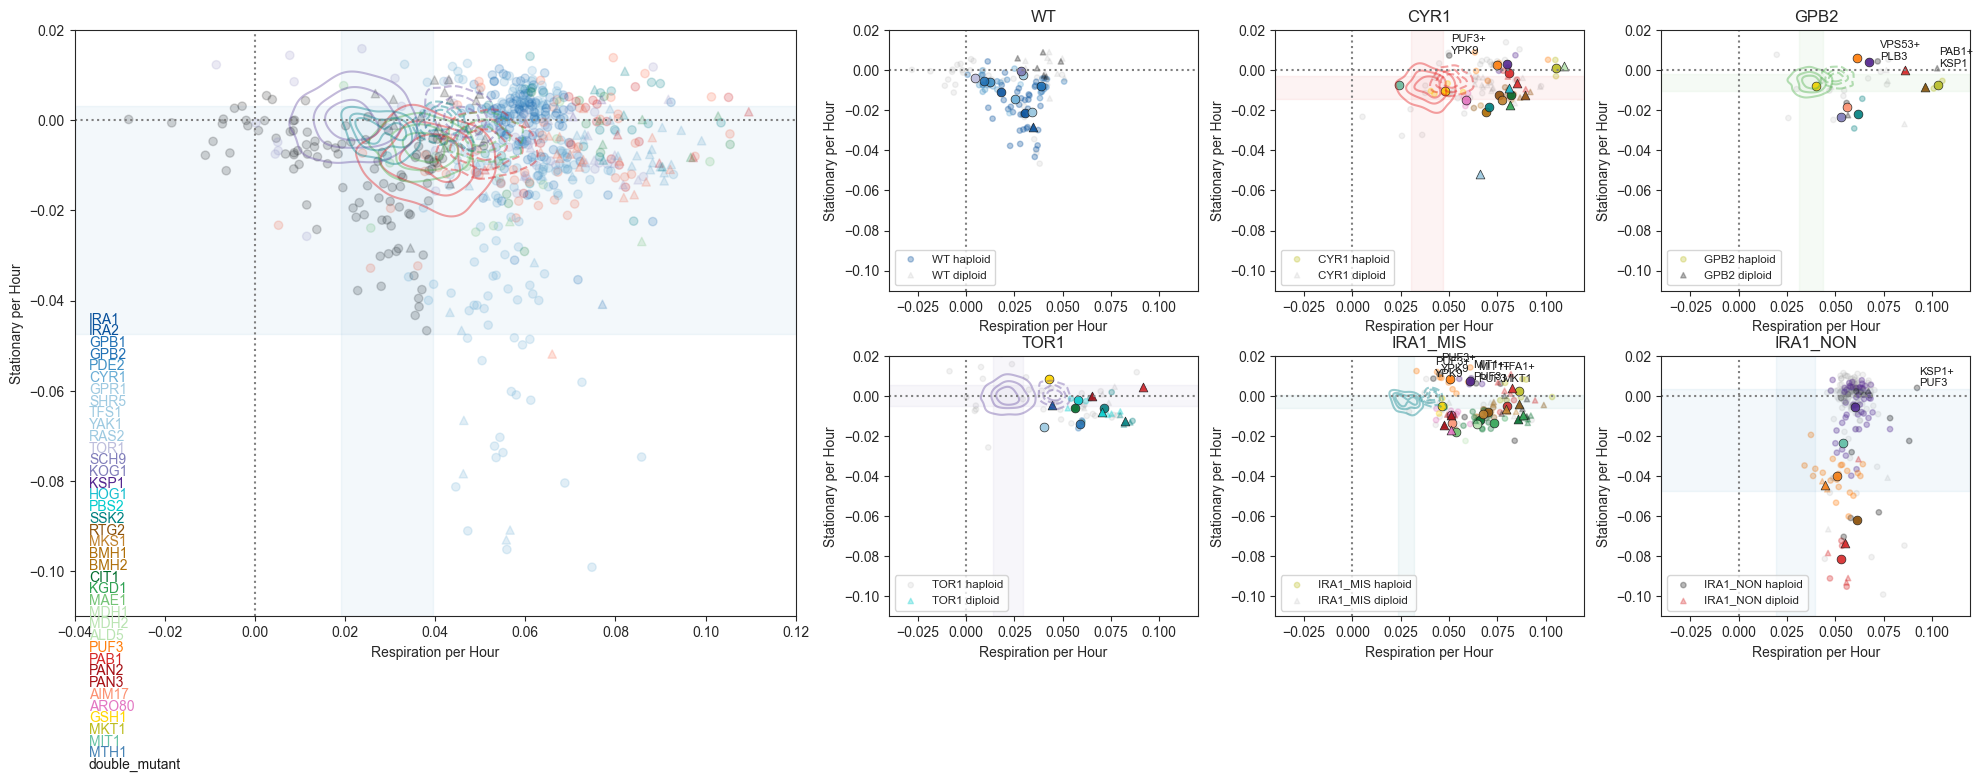

In [23]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
evo_cond_list = ['Evo2D','Evo3D']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        this_anc = this_anc[this_anc['evolution_condition'].isin(evo_cond_list)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
            
        for anc in ancs:
            
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for ploidy,ploidy_list in {'haploid':['Haploid','haploid',np.nan,'?','NotSequenced','other'],'diploid':['diploid','Diploid']}.items():
#         for evo_cond in evo_cond_list:

            gene_list = {}
#             doubles_list = []

            this_data = interesting_muts[interesting_muts['ploidy_new'].isin(ploidy_list)]
            gray_alpha = 0.1
            bold_alpha = 0.3
            if len(ancs) < 2:
                colors = []
                annotation_list = []
                for e,gene in enumerate(this_data['gene'].values):
                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    already_assigned = False
                    if (not p.isnull(gene)) and (gene != 'NotSequenced'):
                        if gene in tools.mutation_color_map.keys():
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map[gene],bold_alpha)
                            
                            if gene in gene_list.keys():
                                gene_list[gene].append(e)
                            else:
                                gene_list[gene] = [e]
                        elif '+' in gene:
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],bold_alpha)
                            
                            if anc != 'WT':
                                if this_data['barcode'].values[e] in innovation_list[f'{xdata}_{ydata}'][f'{anc}']:
                                    annotation_list.append([e,gene])
#                                 else:
#                                     annotation_list.append([e,gene])
#                             if gene in gene_list.keys():
#                                 gene_list[gene].append(e)
#                             else:
#                                 gene_list[gene] = [e]
                        else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    colors.append(color_assigned)
            else:
                colors = [tools.color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
                alpha = 0.2

                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            alpha=alpha,color=colors,marker=tools.ploidy_marker_map[ploidy])
               
                
            else:
                alpha = 0.3
#                 plt.scatter(this_data[xdata].values,this_data[ydata].values,
#                             color=colors,marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
                
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=colors,marker=tools.ploidy_marker_map[ploidy],s=15,label=f'{ancs[0]} {ploidy}')
        
        
                for gene,e_list in gene_list.items():
                
                    gene_centroid = tools.centroid(this_data[[xdata,ydata]].values[e_list,:])
                    
                    plt.scatter(gene_centroid[0],gene_centroid[1],
                            color=colors[e_list[0]],edgecolors='k',linewidth=0.5,
                                marker=tools.ploidy_marker_map[ploidy],s=40,alpha=0.9)
                
    
                for e,doubles in annotation_list:
                    plt.annotate(text=doubles.replace('+','+\n'),xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
                                 xytext=(this_data[xdata].values[e]+0.001,this_data[ydata].values[e]+0.001),
                                 color='k',fontsize=8)

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
                    
        if xdata == 'FerPerHour' and ydata == 'ResPerHour':
            plt.plot(pareto_line[0],pareto_line[1],color='gray',lw=1)

#         for anc in ancs:
        for anc in ancs:
            if anc != 'IRA1_NON':

                x_mean = np.nanmean(this_neutral_haploid[xdata].values)
                x_error = np.nanstd(this_neutral_haploid[xdata].values)
                y_mean = np.nanmean(this_neutral_haploid[ydata].values)
                y_error = np.nanstd(this_neutral_haploid[ydata].values)


                plt.axvspan(x_mean-multiplier*x_error,
                          x_mean+multiplier*x_error,
                          color=tools.anc_color_map[anc],alpha=0.05)

                plt.axhspan(y_mean-multiplier*y_error,
                          y_mean+multiplier*y_error,
                          color=tools.anc_color_map[anc],alpha=0.05)

                tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,
                                                          interesting_muts[ydata].values,
                    x_mean,y_mean,
                    x_error,y_error,
                    multiplier=multiplier)

            else:

                plt.axvspan(background_mutant[xdata].values-multiplier*background_mutant[xdata+'_error'].values,
                          background_mutant[xdata].values+multiplier*background_mutant[xdata+'_error'].values,
                          color=tools.anc_color_map[anc],alpha=0.05)

                plt.axhspan(background_mutant[ydata].values-multiplier*background_mutant[ydata+'_error'].values,
                          background_mutant[ydata].values+multiplier*background_mutant[ydata+'_error'].values,
                          color=tools.anc_color_map[anc],alpha=0.05)

                tradeoffs,n_obs,indices = count_tradeoffs(interesting_muts[xdata].values,interesting_muts[ydata].values,
                     background_mutant[xdata].values,background_mutant[ydata].values,
                    background_mutant[xdata+'_error'].values,background_mutant[ydata+'_error'].values,
                    multiplier=multiplier)
                
#             if anc!='WT'


        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        
        if (xdata == 'FerPerHour') & (ydata == 'ResPerHour'):
            for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
                ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
                resps = (fitness-16*ferms)/28 # 2day = 16*F
                
                
                norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                        vmax=np.nanmax(merged_fitness[fitness_colorby]))

                cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 
                
                plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
                plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')
            
        
        
        if len(ancs) > 1:
            for g,gene in enumerate(tools.mutation_color_map.keys()):
                plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors.pdf',bbox_inches='tight')
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_unannotated_centroids.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_centroids_annotatedInnovations.pdf',bbox_inches='tight')
#     plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_centroids_annotatedInnovations.pdf',bbox_inches='tight')


In [24]:
innovation_list

{'FerPerHour_ResPerHour': {'CYR1': array(['AGAACAAAAACTAAACTCATTCATGG_AGTTAAATTGGGAAGGGTATTTTGAG',
         'GACAGAAAAGCCAAATGGATTTACCG_GAAGAAACAGCGAACAGGCTTTTTTA',
         'AGAACAAAAACTAAACTCATTCATGG_CGGAGAAGTGGCAAGAAGATTGTGAC',
         'CTAGAAATCTCAAAAACTTTTGGCTG_ATCTAAATCCAAAAACCTTTTGTATG',
         'GACAGAAAAGCCAAATGGATTTACCG_GACCCAAAAGACAACCCGTTTTAGTG',
         'GACAGAAAAGCCAAATGGATTTACCG_CGCGAAAATAGCTACACTGTTTCACG',
         'AGAACAAAAACTAAACTCATTCATGG_AGGGAAACCGGAAAGATTATTTGGTG',
         'AGAACAAAAACTAAACTCATTCATGG_AGAAGAAAACTCAATTAGCTTAGATC',
         'AGAACAAAAACTAAACTCATTCATGG_GAGTTAAAATCTAAATTCCTTCTCGA',
         'GACAGAAAAGCCAAATGGATTTACCG_CAGGTAACCAAGAAAGACTTTGTAAG',
         'CTAGAAATCTCAAAAACTTTTGGCTG_GCATTAAGACAGAATGAATTTTTTTT',
         'GACAGAAAAGCCAAATGGATTTACCG_TGACTAAATGGAAACAGCGTTGTTCG',
         'AGAACAAAAACTAAACTCATTCATGG_GCAATAAAGGAAAAAGACGTTGAGC',
         'AGAACAAAAACTAAACTCATTCATGG_TCTAAAAGCTGAAACGTATTTGTGGA',
         'GACAGAAAAGCCAAATGGATTTACCG_CCCACAA